# Stations DiSC
**Purpose:** Analyze the *results*, *random error*, and *systematic error* for the DiSC sensors used during measurement of air pollution on the Stockholm subway platforms.

## Setup

In [1]:
################################
# LIBRARIES
################################
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.util import *
from src.frames import *
from src.stats import *
from src.plots import *

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None  # default='warn'

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read Session df, and raw session df
s_df = pd.read_csv('../results/sessions/disc.csv')
r_df = pd.read_csv('../results/sessions/disc_raw.csv')

# Convert sensor column to string
r_df['Sensor'] = r_df['Sensor'].astype(str)

# Only keep stations from the green line
s_df = s_df[s_df['Station'].isin(get_green_line())]
r_df = r_df[r_df['Station'].isin(get_green_line())]

# Sort by green line
green_line_order = CategoricalDtype(get_green_line(), ordered=True)

s_df['Station Order'] = s_df['Station'].astype(green_line_order)
r_df['Station Order'] = r_df['Station'].astype(green_line_order)

s_df = s_df.sort_values('Station Order')
r_df = r_df.sort_values('Station Order')

# Keep a record of station id's
session_ids = sorted(list(r_df["Session Id"].unique()))

# Convert to int
r_df["Size"] = r_df["Size"].apply(lambda x: float(x.replace(",", ".")))
r_df["LDSA"] = r_df["LDSA"].apply(lambda x: float(x.replace(",", ".")))
r_df["Diff"] = r_df["Diff"].apply(lambda x: float(x.replace(",", ".")))
r_df["Filter"] = r_df["Filter"].apply(lambda x: float(x.replace(",", ".")))

# Choose what param to be analyzed
param = 'Number'
unit = '#/cm³'

# figure folder
fig_folder = '../results/stations_disc'


## Overview Statistics

### Number of sessions

In [3]:
### Sessions per station
def total_count(x):
    return len(x)

def morning_rush_count(x):
    if 'Morning rush' not in x.values:
        return 0
    
    return x.value_counts()['Morning rush']

def evening_rush_count(x):
    if 'Evening rush' not in x.values:
        return 0
        
    return x.value_counts()['Evening rush']

def offtime_count(x):
    if 'Offtime' not in x.values:
        return 0
        
    return x.value_counts()['Offtime']

session_count = s_df.groupby('Station').agg({'Period': [total_count, morning_rush_count, evening_rush_count, offtime_count]})

print(f'Total unique sessions: {len(s_df["Session Id"].unique())}')

session_count = session_count['Period'].sort_values(by='total_count', ascending=False)
session_count.loc['Total'] = session_count.sum()

session_count.to_csv(f'{fig_folder}/tables/session_counts({param}).csv')

session_count


Total unique sessions: 23


total_count  morning_rush_count  evening_rush_count  \
Station                                                                 
Odenplan                   18                   9                   5   
St Eriksplan               12                   6                   5   
T-Centralen                12                   6                   3   
Fridhemsplan               12                   6                   5   
Hötorget                   12                   6                   3   
Kristineberg               12                   6                   4   
Alvik                      12                   6                   4   
Rådmansgatan               12                   6                   3   
Slussen                    11                   5                   3   
Medborgarplatsen           10                   5                   3   
Thorildsplan               10                   5                   3   
Gamla Stan                 10                   5                   3   
Skanstull                  10                   5                   3   
Gullmarsplan                9                   4                   3   
Stora mossen                6                   2                   3   
Abrahamsberg                6                   2                   2   
Brommaplan                  6                   2                   2   
Åkeshov                     5                   2                   1   
Islandstorget               2                   1                   0   
Angbyplan                   1                   1                   0   
Total                     188                  90                  58   

                  offtime_count  
Station                          
Odenplan                      4  
St Eriksplan                  1  
T-Centralen                   3  
Fridhemsplan                  1  
Hötorget                      3  
Kristineberg                  2  
Alvik                         2  
Rådmansgatan                  3  
Slussen                       3  
Medborgarplatsen              2  
Thorildsplan                  2  
Gamla Stan                    2  
Skanstull                     2  
Gullmarsplan                  2  
Stora mossen                  1  
Abrahamsberg                  2  
Brommaplan                    2  
Åkeshov                       2  
Islandstorget                 1  
Angbyplan                     0  
Total                        40

## General statistics
Grand mean, median, mode, standard deviation and confidence interval

In [4]:
general_stats = s_df.groupby('Station').agg({param: ['mean', 'median', mode, 'min', 'max', x_range, sample_std, CI95, CV, standard_error]})
general_stats['order index'] = [get_green_line().index(name) for name in general_stats[param].index]

general_stats.to_csv(f'{fig_folder}/tables/general_stats({param}).csv')
general_stats['Number'].sort_values('mean', ascending=False)


mean       median         mode          min  \
Station                                                                 
Kristineberg      10473.270106  6125.671429  2695.785714  2695.785714   
Gullmarsplan       5814.444457  4246.000000  1405.240000  1405.240000   
Thorildsplan       5797.754053  4877.550000  2021.352941  2021.352941   
Skanstull          5763.703829  5266.714286  4256.384615  4256.384615   
Slussen            4908.356381  4646.000000  3458.833333  3458.833333   
Gamla Stan         4660.625795  4345.250000  2988.114286  2988.114286   
Medborgarplatsen   4379.148663  4342.970588  3236.921053  3236.921053   
Alvik              4331.481751  4257.560150  2039.714286  2039.714286   
Rådmansgatan       4326.794861  4250.150000  2501.512821  2501.512821   
St Eriksplan       4043.402667  3782.215909  2699.666667  2699.666667   
Odenplan           3917.315028  3915.332031  2158.307692  2158.307692   
T-Centralen        3474.405613  3180.721429  2663.516129  2663.516129   
Stora mossen       3210.628968  2707.166667  2248.142857  2248.142857   
Fridhemsplan       3053.771098  3046.325000  1977.357143  1977.357143   
Hötorget           3033.433582  2945.525000  2304.000000  2304.000000   
Abrahamsberg       2966.285403  2596.722222  1348.111111  1348.111111   
Brommaplan         2752.618412  2257.871032  1898.285714  1898.285714   
Åkeshov            2692.503416  2051.750000  1831.142857  1831.142857   
Angbyplan          2292.000000  2292.000000  2292.000000  2292.000000   
Islandstorget      2090.461538  2090.461538  2059.000000  2059.000000   

                           max       x_range   sample_std         CI95  \
Station                                                                  
Kristineberg      26939.800000  24244.014286  8134.839467  4602.718721   
Gullmarsplan      11210.923077   9805.683077  3329.026090  2174.963712   
Thorildsplan      11506.166667   9484.813725  3303.720319  2047.667068   
Skanstull          9022.818182   4766.433566  1527.472349   946.737170   
Slussen            6736.666667   3277.833333  1072.876145   634.029285   
Gamla Stan         7670.600000   4682.485714  1479.364109   916.919374   
Medborgarplatsen   6412.652174   3175.731121  1037.267149   642.904840   
Alvik              6637.000000   4597.285714  1823.658650  1031.832016   
Rådmansgatan       6244.100000   3742.587179  1169.974342   661.975301   
St Eriksplan       8289.500000   5589.833333  1504.003468   850.970071   
Odenplan           6776.250000   4617.942308  1026.408558   474.176562   
T-Centralen        4776.666667   2113.150538   814.242401   460.701008   
Stora mossen       5996.583333   3748.440476  1420.747877  1136.835069   
Fridhemsplan       4335.250000   2357.892857   731.650364   413.970164   
Hötorget           4183.272727   1879.272727   609.417855   344.810612   
Abrahamsberg       6061.823529   4713.712418  1678.829602  1343.343457   
Brommaplan         5542.250000   3643.964286  1406.950974  1125.795246   
Åkeshov            4937.000000   3105.857143  1308.143292  1146.638152   
Angbyplan          2292.000000      0.000000          NaN          NaN   
Islandstorget      2121.923077     62.923077    44.493334    61.664615   

                        CV  standard_error  
Station                                     
Kristineberg      0.776724     2348.325878  
Gullmarsplan      0.572544     1109.675363  
Thorildsplan      0.569828     1044.728096  
Skanstull         0.265016      483.029169  
Slussen           0.218582      323.484329  
Gamla Stan        0.317417      467.816007  
Medborgarplatsen  0.236865      328.012673  
Alvik             0.421024      526.444906  
Rådmansgatan      0.270402      337.742501  
St Eriksplan      0.371965      434.168404  
Odenplan          0.262018      241.926817  
T-Centralen       0.234354      235.051535  
Stora mossen      0.442514      580.017892  
Fridhemsplan      0.239589      211.209267  
Hötorget          0.200900      175.923781  
Abrahamsberg      0.56597

In [5]:
inside_stations = [
    'Fridhemsplan', 
    'St Eriksplan', 
    'Odenplan', 
    'Rådmansgatan', 
    'Hötorget', 
    'T-Centralen', 
    'Slussen', 
    'Medborgarplatsen',
    'Skanstull'
]

dist_df = s_df.copy()
dist_df['Inside'] = dist_df['Station'].apply(lambda x: x in inside_stations)

dist_df.groupby('Inside').agg({param: ['mean', CI95]})

Number            
               mean        CI95
Inside                         
False   5165.613389  971.345582
True    4046.915683  245.962884

In [6]:
len(list(dist_df[dist_df['Inside'] == True]['Station'].unique()))

9

## Distribution

### Box Plot 1

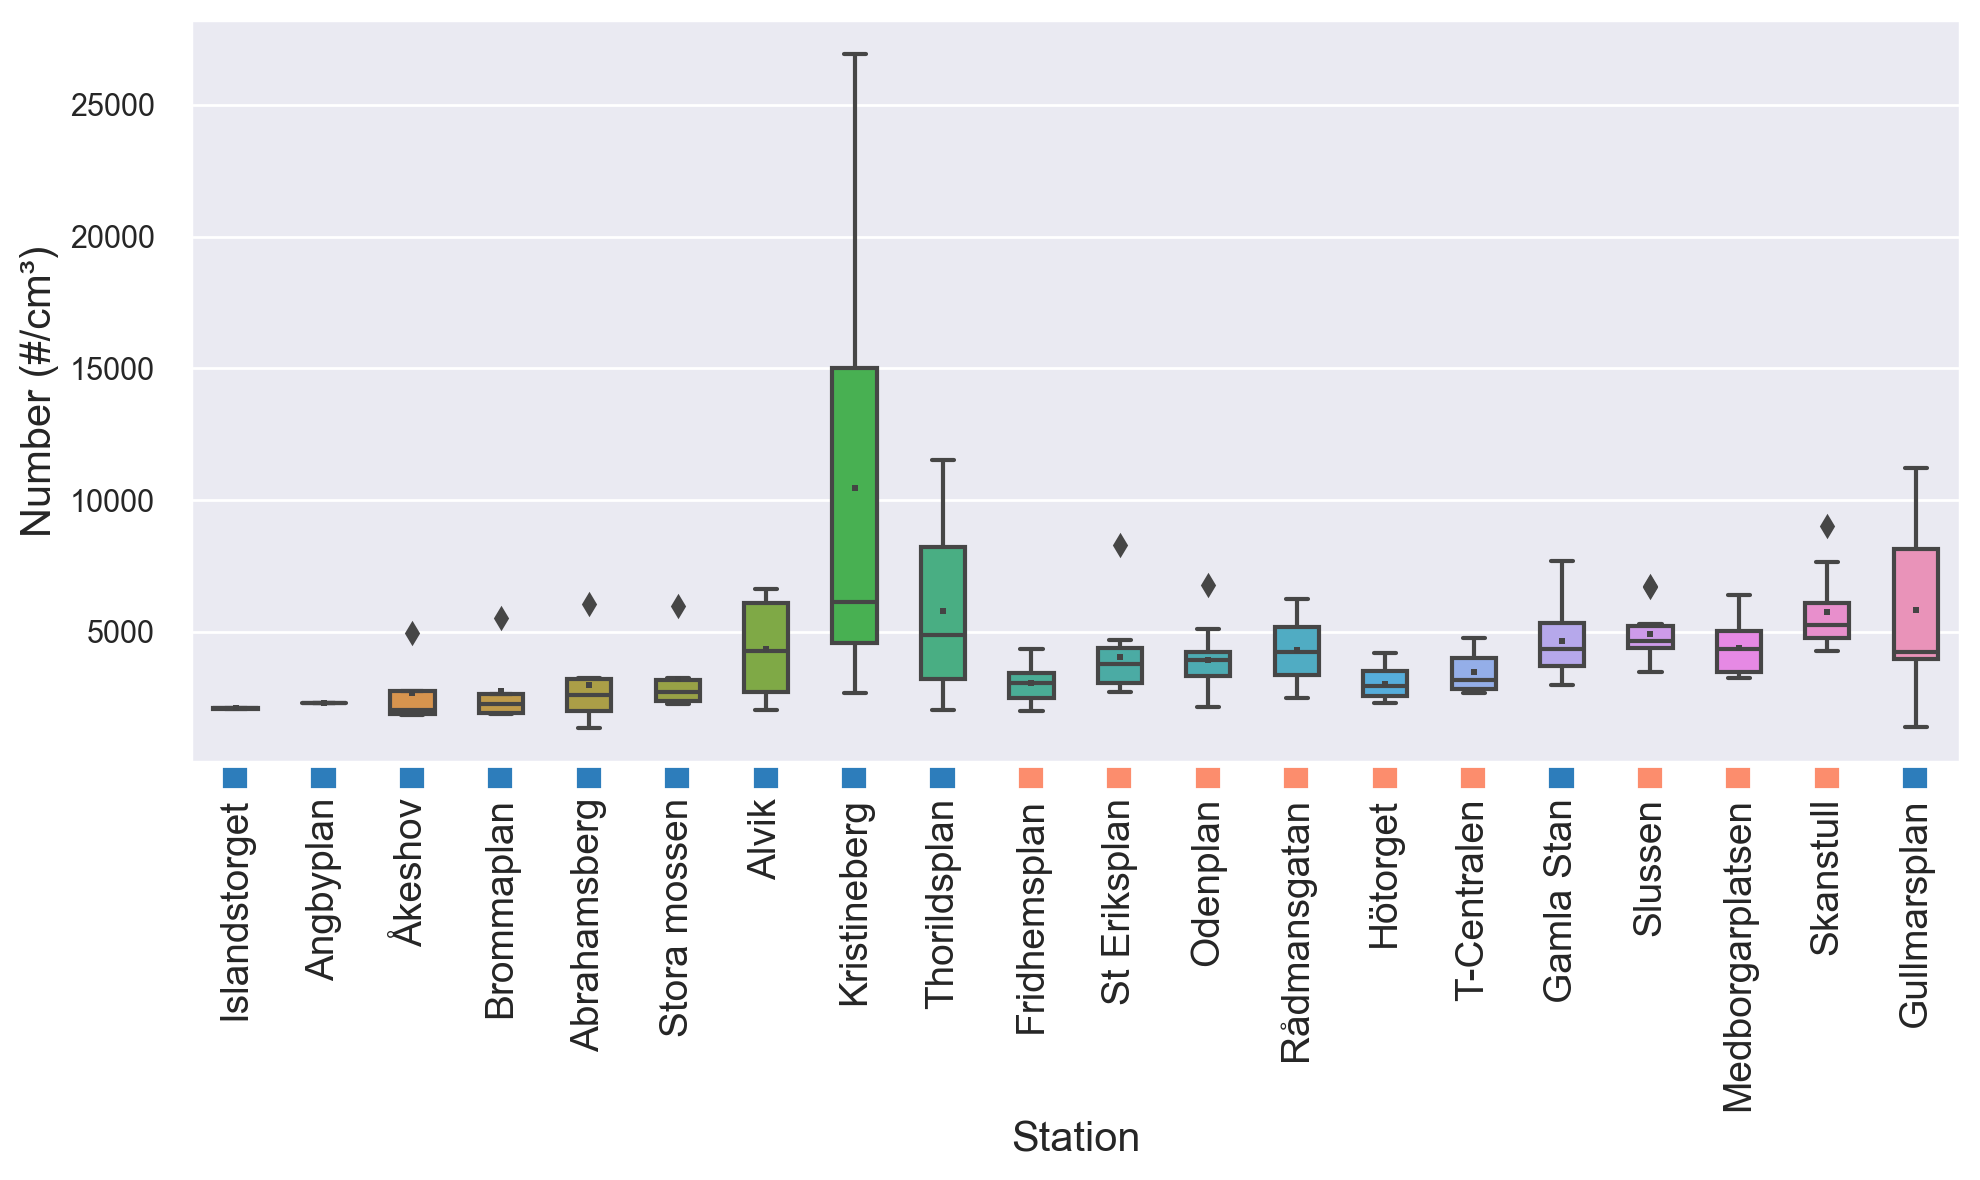

In [12]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Station', y=param, data=s_df, width=0.5, order=get_green_line(), showmeans=True,
    #meanline=True, 
    meanprops={"marker": 's',
                "markerfacecolor":"#444", 
                "markersize":"2"
    })
plt.xticks(rotation=90, fontsize=14)
#plt.title('Box Plots Stations')
plt.ylabel(fr"{param} ({unit})", fontsize=15)
plt.xlabel(fr"Station", fontsize=15)

# Change color of xticks
inside_c = '#FC8D6D'
outside_c = '#2D7DBB'

i = 0
for t in ax.xaxis.get_ticklabels():
    
    c = inside_c if t.get_text() in get_inside_stations() else outside_c
    
    ax.text(
        i - 0.04, -520, 
        ' ',
        fontsize = 2, 
        zorder = 6, 
        color = 'k', 
        rotation=90, 
        bbox={'facecolor': c, 'pad':4}
    )
    
    i += 1
    
plt.tight_layout()
plt.savefig(f'{fig_folder}/box_plots_color({param}).pdf', dpi=300, bbox_inches="tight")
plt.show()

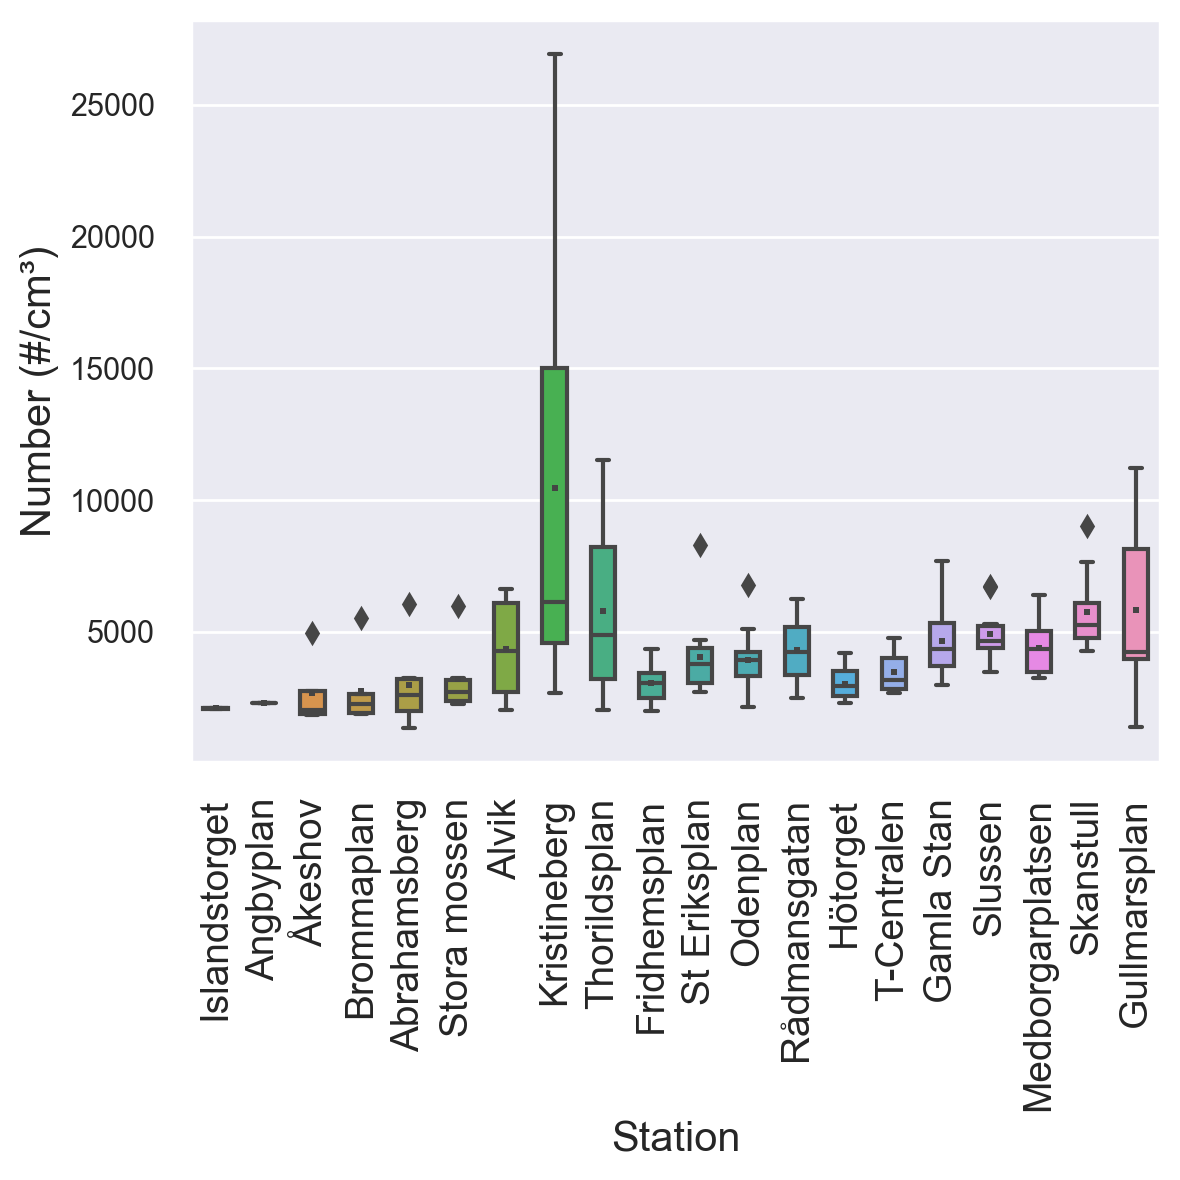

In [3]:
fig, ax = plt.subplots(figsize=[6,6], dpi=200)

sns.boxplot(x='Station', y=param, data=s_df, width=0.5, order=get_green_line(), showmeans=True,
    #meanline=True, 
    meanprops={"marker": 's',
                "markerfacecolor":"#444", 
                "markersize":"2"
    })
plt.xticks(rotation=90, fontsize=14)
#plt.title('Box Plots Stations')
plt.ylabel(fr"{param} ({unit})", fontsize=15)
plt.xlabel(fr"Station", fontsize=15)
plt.tight_layout()
plt.savefig(f'{fig_folder}/box_plots({param})_tight.pdf', dpi=300, bbox_inches="tight")
plt.show()

### Quantiles and outliers

In [41]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
station_quantiles = s_df.groupby('Station').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

station_quantiles.to_csv(f'{fig_folder}/tables/station_quantiles({param}).csv')
station_quantiles[param].sort_values(by='outliers', ascending=False)

Q1           Q2            Q3           IQR  \
Station                                                                  
Slussen           4405.277778  4646.000000   5232.223982    826.946204   
Abrahamsberg      1983.250000  2596.722222   3210.861111   1227.611111   
Odenplan          3339.611328  3915.332031   4220.732143    881.120815   
Stora mossen      2378.750000  2707.166667   3178.369048    799.619048   
St Eriksplan      3073.357143  3782.215909   4372.566667   1299.209524   
Skanstull         4767.796935  5266.714286   6110.995629   1343.198695   
Åkeshov           1885.928571  2051.750000   2756.695652    870.767081   
Brommaplan        1926.100694  2257.871032   2622.409341    696.308646   
Hötorget          2580.452206  2945.525000   3531.666667    951.214461   
Islandstorget     2074.730769  2090.461538   2106.192308     31.461538   
Kristineberg      4583.138889  6125.671429  15026.275000  10443.136111   
Alvik             2702.053571  4257.560150   6089.276786   3387.223214   
Gullmarsplan      3972.259259  4246.000000   8126.800000   4154.540741   
Rådmansgatan      3343.464286  4250.150000   5198.987500   1855.523214   
Gamla Stan        3716.653846  4345.250000   5330.233007   1613.579161   
Fridhemsplan      2478.104167  3046.325000   3418.750000    940.645833   
Angbyplan         2292.000000  2292.000000   2292.000000      0.000000   
T-Centralen       2831.522727  3180.721429   3994.979167   1163.456439   
Thorildsplan      3197.688312  4877.550000   8218.850000   5021.161688   
Medborgarplatsen  3479.012500  4342.970588   5015.966667   1536.954167   

                    lowerLimit    upperLimit  outliers  prcnt_outliers  count  
Station                                                                        
Slussen            3164.858472   6472.643288       2.0       18.181818     11  
Abrahamsberg        141.833333   5052.277778       1.0       16.666667      6  
Odenplan           2017.930106   5542.413365       1.0        5.555556     18  
Stora mossen       1179.321429   4377.797619       1.0       16.666667      6  
St Eriksplan       1124.542857   6321.380952       1.0        8.333333     12  
Skanstull          2752.998893   8125.793671       1.0       10.000000     10  
Åkeshov             579.777950   4062.846273       1.0       20.000000      5  
Brommaplan          881.637725   3666.872310       1.0       16.666667      6  
Hötorget           1153.630515   4958.488358       0.0        0.000000     12  
Islandstorget      2027.538462   2153.384615       0.0        0.000000      2  
Kristineberg     -11081.565278  30690.979167       0.0        0.000000     12  
Alvik             -2378.781250  11170.111607       0.0        0.000000     12  
Gullmarsplan      -2259.551852  14358.611111       0.0        0.000000      9  
Rådmansgatan        560.179464   7982.272321       0.0        0.000000     12  
Gamla Stan         1296.285105   7750.601748       0.0        0.000000     10  
Fridhemsplan       1067.135417   4829.718750       0.0        0.000000     12  
Angbyplan          2292.000000   2292.000000       0.0        0.000000      1  
T-Centralen        1086.338068   5740.163826       0.0        0.000000     12  
Thorildsplan      -4334.054221  15750.592532       0.0        0.000000     10  
Medborgarplatsen   1173.581250   7321.397917       0.0        0.000000     10

**Comment**

Some stations have outliers. What happened during these sessions?

In [42]:
outlier_ids = print_outliers(s_df, station_quantiles, param)

=== OUTLIERS ===
Abrahamsberg:
	20210929-2 - Number = 6061.82

Brommaplan:
	20210929-2 - Number = 5542.25

Odenplan:
	20211001-3 - Number = 6776.25

Skanstull:
	20211008-1 - Number = 9022.82

Slussen:
	20210930-3 - Number = 6736.67
	20211004-1 - Number = 6685.18

St Eriksplan:
	20211001-3 - Number = 8289.5

Stora mossen:
	20210929-2 - Number = 5996.58

Åkeshov:
	20210929-2 - Number = 4937.0

Unique outliers: ['20210929-2', '20210930-3', '20211001-3', '20211004-1', '20211008-1']


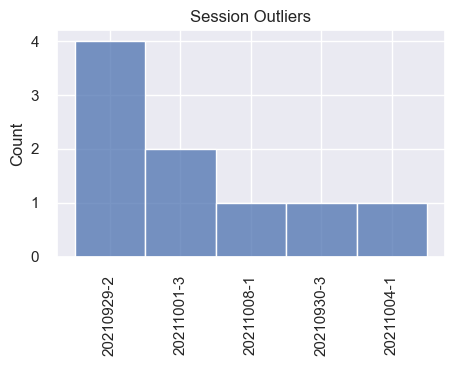

In [43]:
fig, ax = plt.subplots(figsize=[5, 3], dpi=100)

sns.histplot(outlier_ids)
plt.title('Session Outliers')
plt.xticks(rotation=90)
plt.show()

**Comment**

These sessions are worth examining and comparing with other sources. Especially session 20211004-2, as it contains 5 outliers within the same session!

In [44]:
param = 'Number'

s_id = '20211005-1'

tmp1 = s_df[s_df['Session Id'] == s_id][['Station', param]]

tmp2 = s_df.groupby('Station').agg({param: 'mean'})[param][list(tmp1.Station.unique())]
tmp2 = tmp2.to_frame()

tmp2['Station'] = tmp2.index
tmp2 = tmp2.reset_index(drop=True)

tmp2 = tmp2.rename(columns={param: f'{param} Mean'})

tmp = pd.merge(tmp1, tmp2, on='Station')

tmp['Diff'] = tmp[param] - tmp[f'{param} Mean']

print(get_middle_value(s_df[s_df['Session Id'] == s_id], 'Timestamp'))

tmp

IndexError: single positional indexer is out-of-bounds

## Rush and off hours

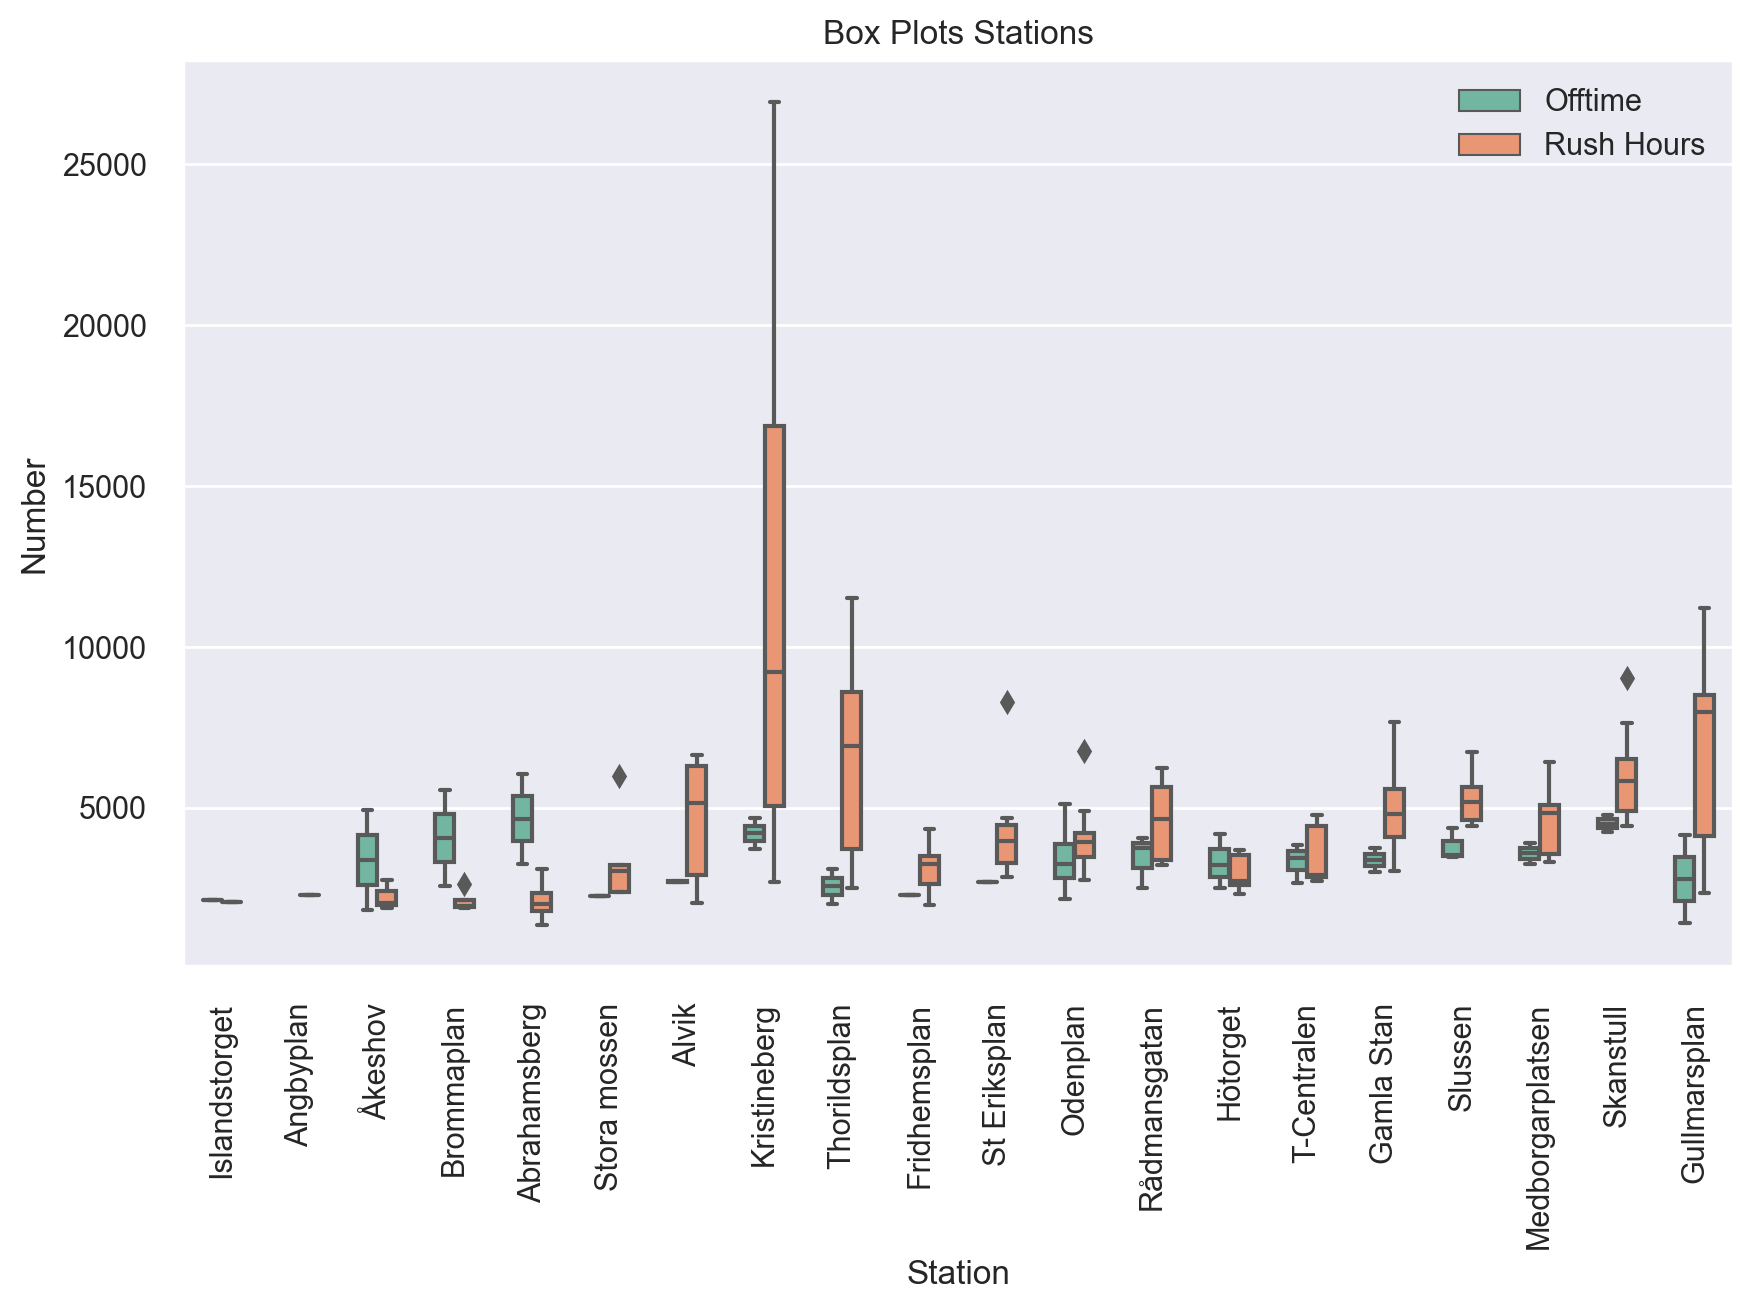

In [45]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

plot_df = s_df.copy()
plot_df['Period'] = plot_df['Period'].apply(lambda x: 'Rush Hours' if x in ['Evening rush', 'Morning rush'] else x)

sns.boxplot(
    x='Station', 
    y=param, 
    data=plot_df, 
    width=0.5, 
    order=get_green_line(), 
    hue='Period',
    palette="Set2"
)

plt.legend()
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots_rush_vs_offtime({param}).pdf')

plt.show()

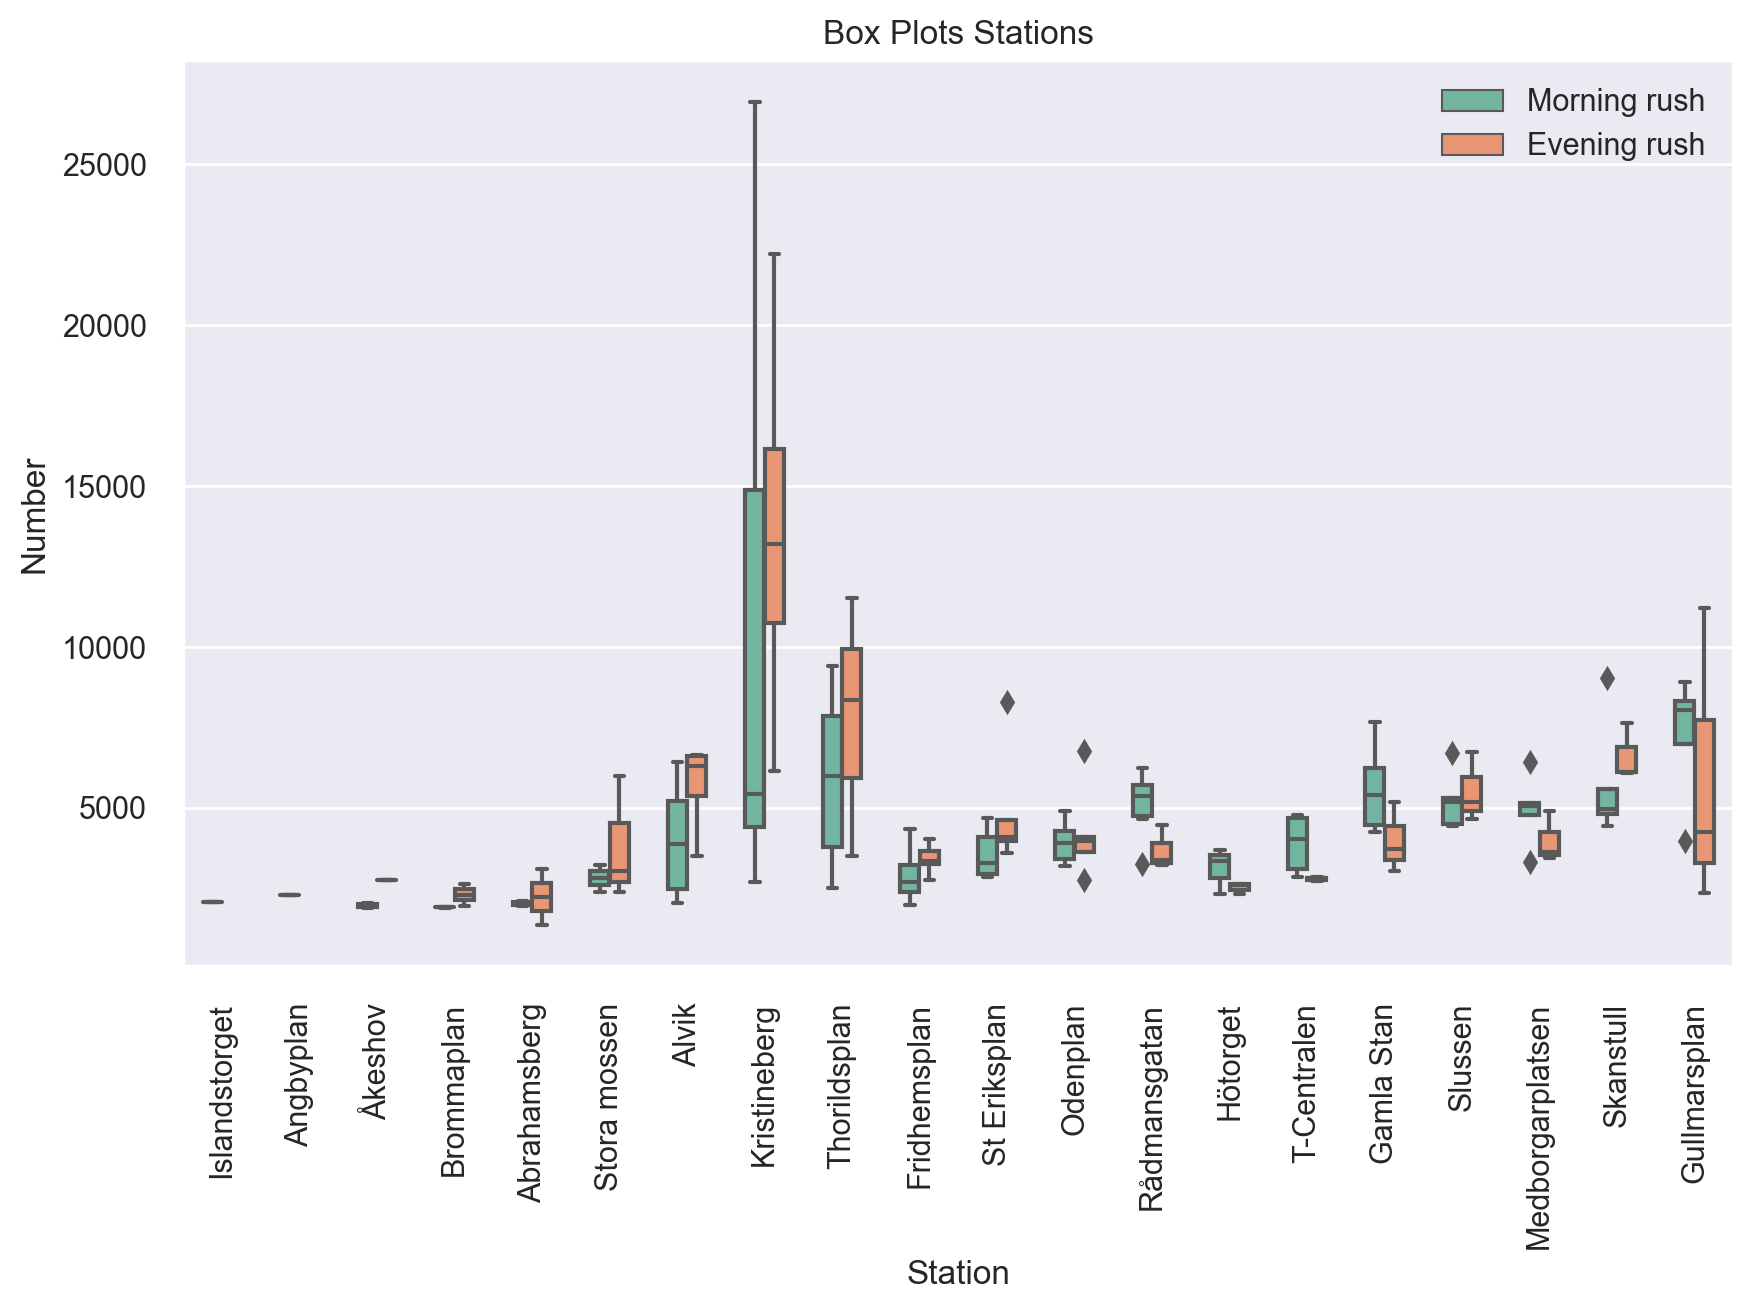

In [46]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

plot_df = s_df.loc[s_df['Period'] != 'Offtime']

sns.boxplot(
    x='Station', 
    y=param, 
    data=plot_df, 
    width=0.5, 
    order=get_green_line(), 
    hue='Period',
    palette="Set2"
)

plt.legend()
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots_morning_evening_rush({param}).pdf')

plt.show()

### Histograms

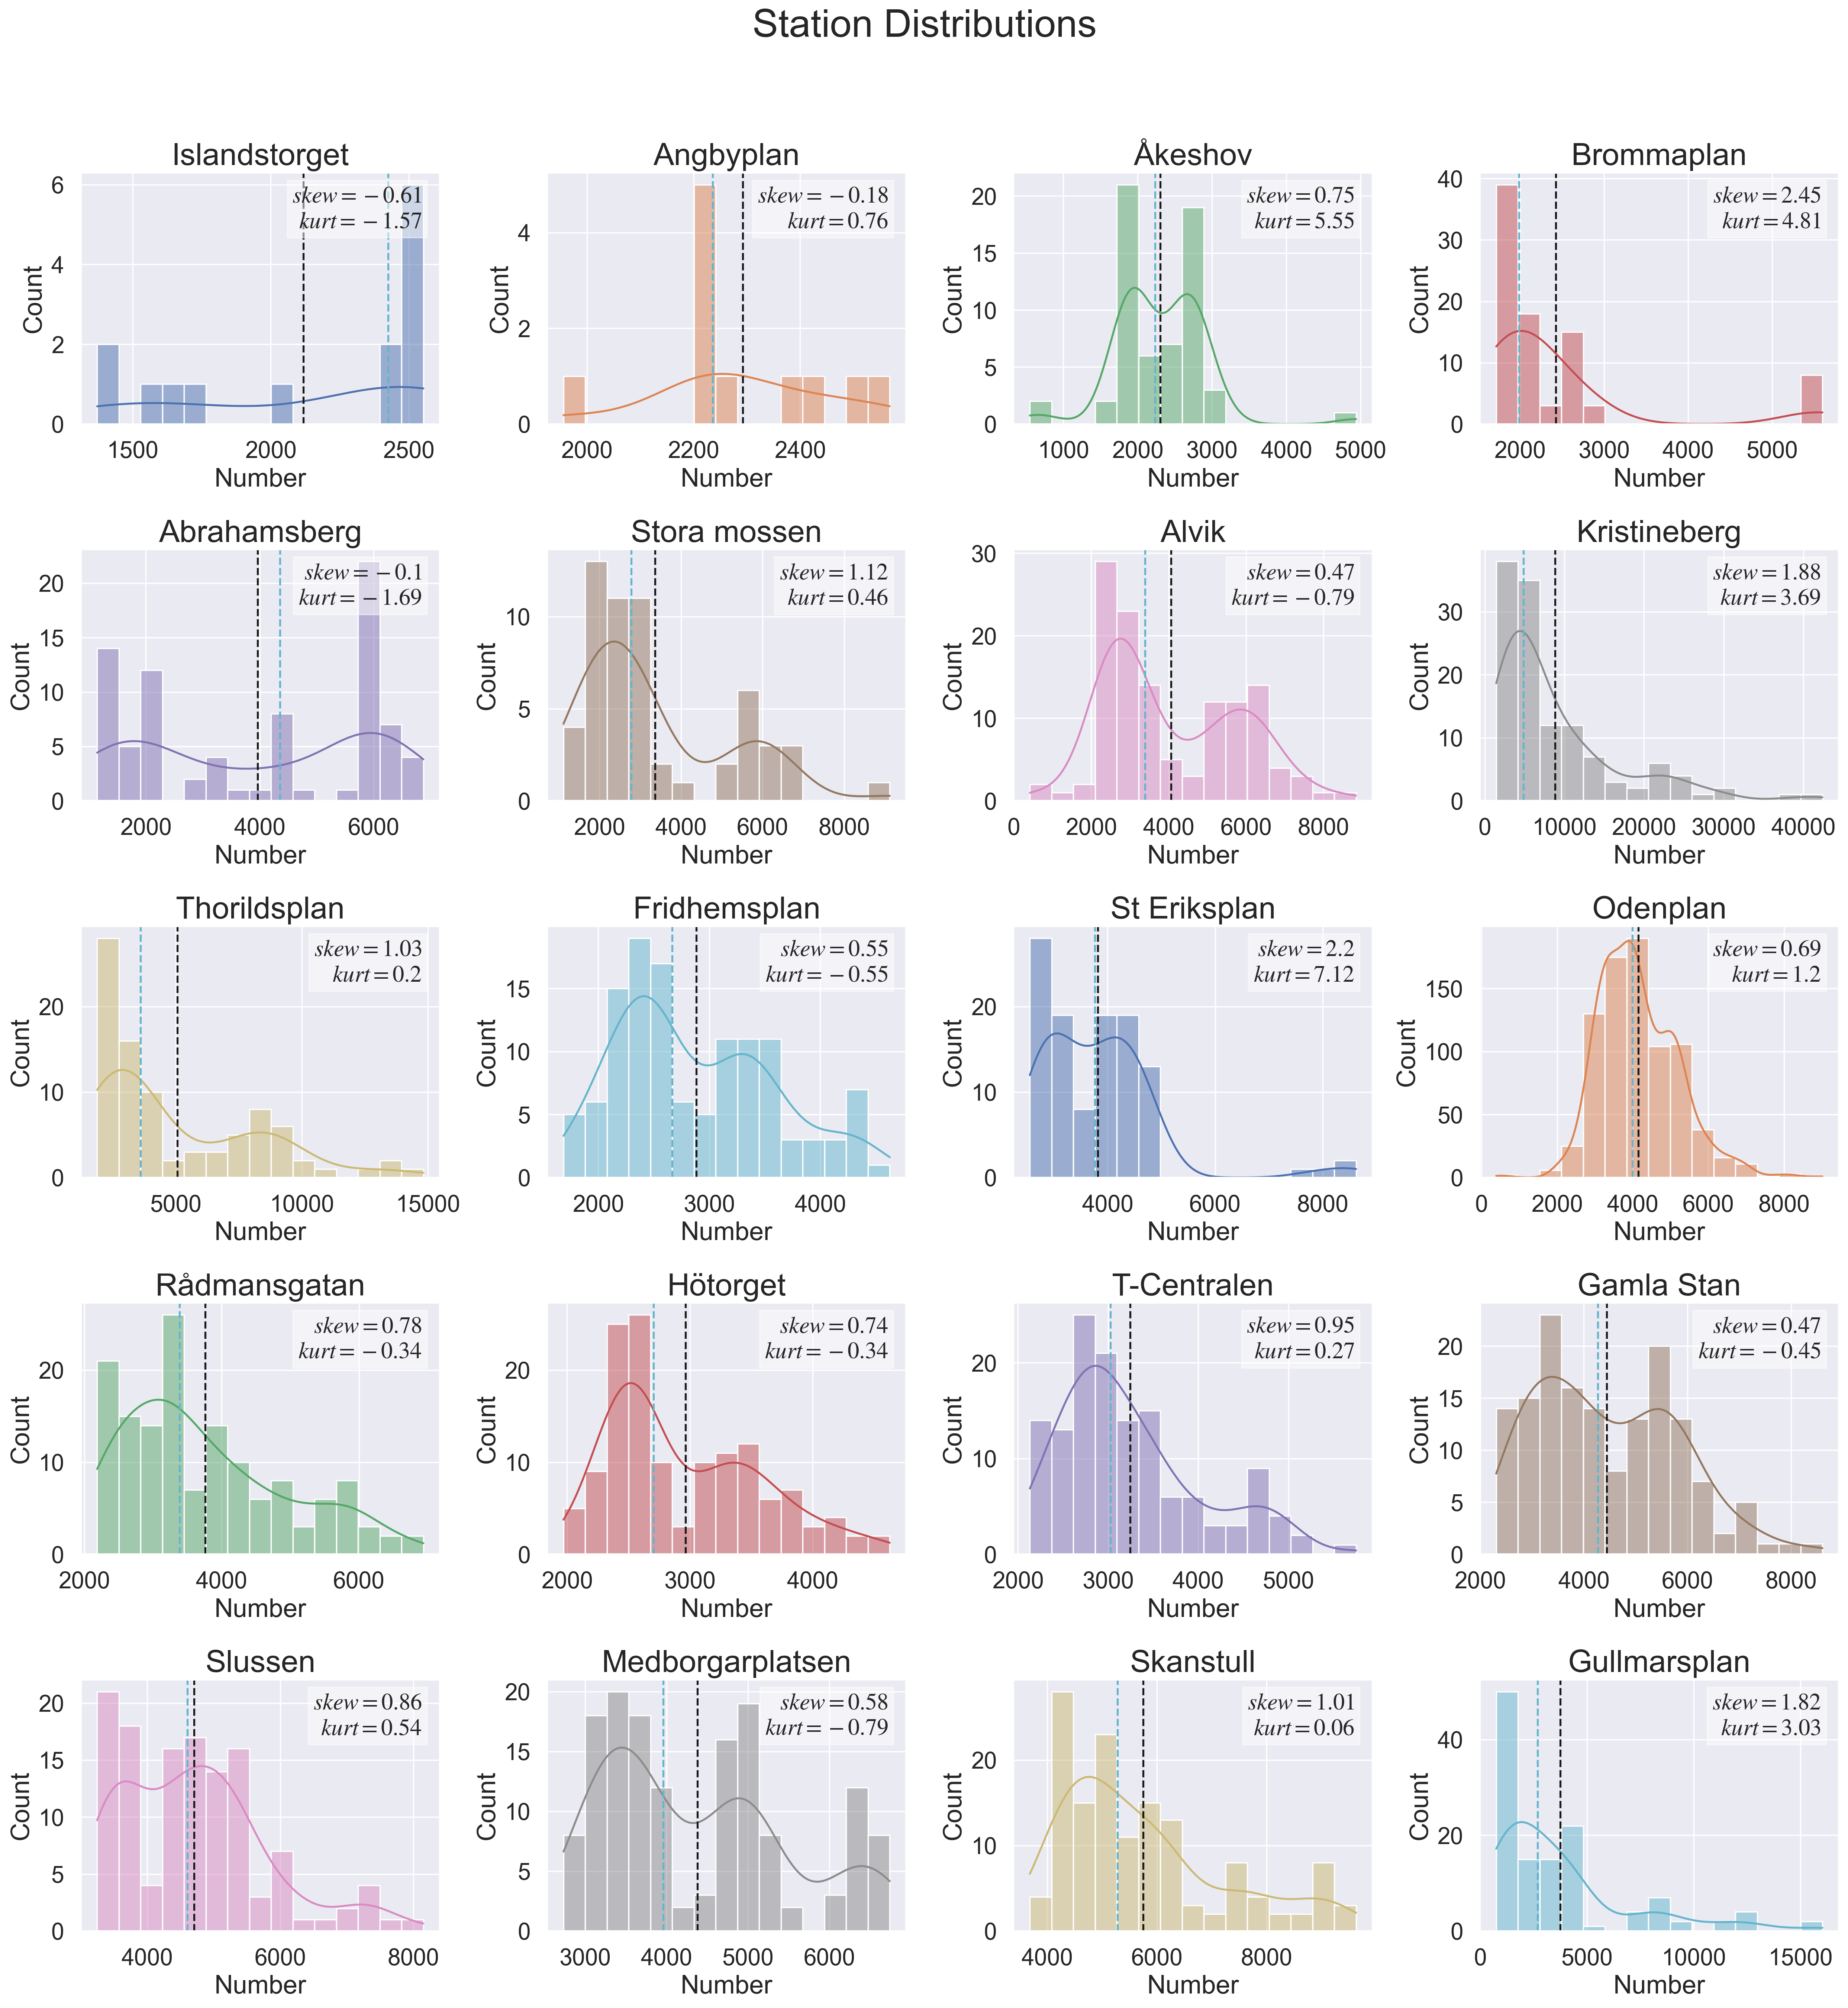

In [47]:
plot_distributions(
    df=r_df, 
    dist_col='Station', 
    title='Station Distributions', 
    fig_name=f'{fig_folder}/distributions({param}).pdf',
    param=param,
    with_textbox=True,
    column_count=4,
    bins=15
)

### Normal distribution

In [48]:
normal = r_df.groupby('Station').agg({param: [skew, kurtosis]})
normal[param].to_csv(f'{fig_folder}/tables/normal({param}).csv')

normal

Number          
                      skew  kurtosis
Station                             
Abrahamsberg     -0.097132 -1.692824
Alvik             0.470356 -0.792592
Angbyplan        -0.179674  0.758497
Brommaplan        2.447037  4.808506
Fridhemsplan      0.545382 -0.550353
Gamla Stan        0.469013 -0.451041
Gullmarsplan      1.815205  3.032087
Hötorget          0.740249 -0.335916
Islandstorget    -0.613254 -1.570417
Kristineberg      1.882965  3.690114
Medborgarplatsen  0.579622 -0.790915
Odenplan          0.691732  1.195728
Rådmansgatan      0.775282 -0.337195
Skanstull         1.005500  0.060425
Slussen           0.863349  0.535125
St Eriksplan      2.196977  7.119544
Stora mossen      1.116313  0.463345
T-Centralen       0.954893  0.271147
Thorildsplan      1.034615  0.196850
Åkeshov           0.752575  5.552646

#### QQ Plots

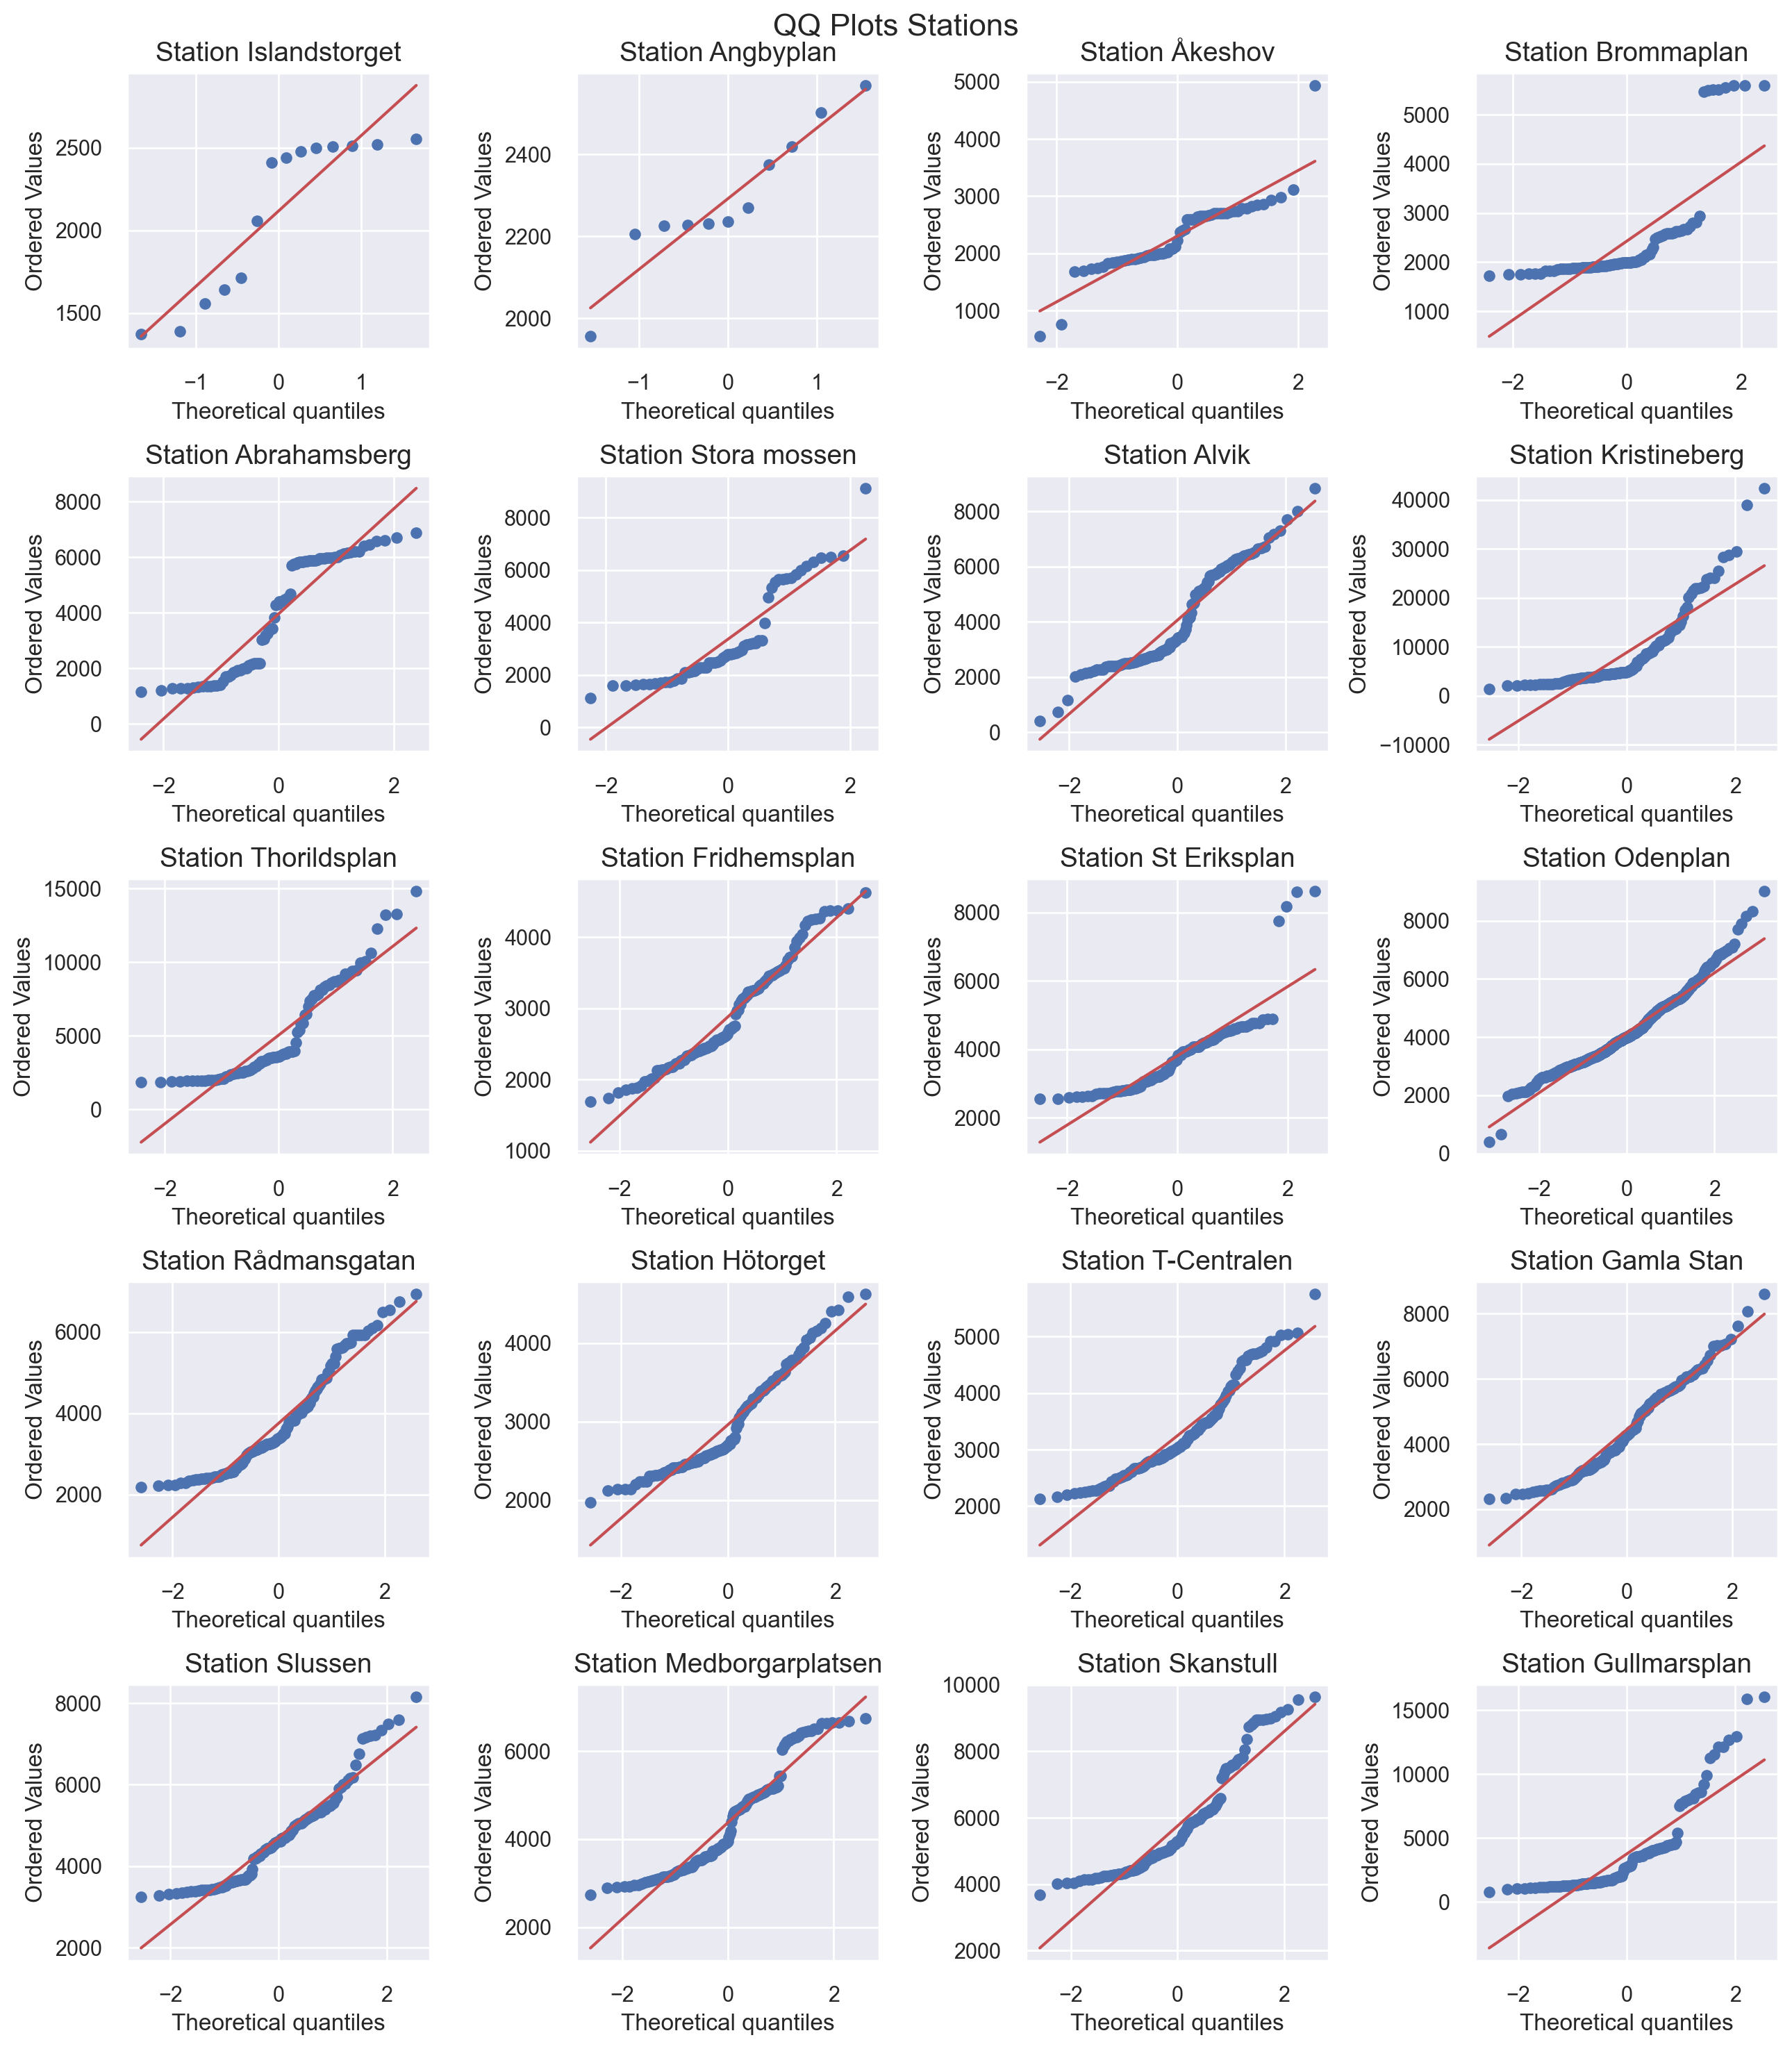

In [49]:
plot_QQ_plots(
    r_df, 
    title='QQ Plots Stations', 
    param=param, 
    fig_name=f'{fig_folder}/QQPlots({param}).pdf',
    col_count=4,
    row_count=5,
    label='Station',
    size=(13, 15)
)

### Sensor diffs

How much do the sensor means per session per station differ? Compute standard deviation per session per station.

In [50]:
station_diffs = {}

for session_id, grp in r_df.groupby('Session Id'):
    for station, station_grp in grp.groupby('Station'):
        if station not in station_diffs:
            station_diffs[station] = []
            
        # Compute std
        station_diffs[station].append(sample_std(station_grp[param].values))
            
# Convert into one long array and make a histogram
station_diffs

mean_station_diffs = {s: np.nanmean(v) for s, v in station_diffs.items()}
mean_station_diffs

station_diffs_df = pd.DataFrame(list(mean_station_diffs.items()), columns=['station', 'mean sensor std'])
station_diffs_df['order'] = [get_green_line().index(station) for station in mean_station_diffs.keys()]

print(f'Total mean sensor diff: {station_diffs_df["mean sensor std"].mean()}')

station_diffs_df.to_csv(f'{fig_folder}/tables/sensors_diffs_per_station({param}).csv')

station_diffs_df.sort_values(by=['mean sensor std'], ascending=False)

Total mean sensor diff: 536.7538868414842


/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


station  mean sensor std  order
14      Kristineberg      3323.150684      7
16      Stora mossen       888.180852      5
17      Thorildsplan       857.511797      8
1       Gullmarsplan       784.821566     19
10             Alvik       525.447667      6
13     Islandstorget       492.660543      0
6          Skanstull       431.707694     18
4           Odenplan       397.735367     11
0         Gamla Stan       380.963058     15
9       Abrahamsberg       380.116869      4
18           Åkeshov       346.422982      2
7            Slussen       338.123731     16
8        T-Centralen       301.853342     14
5       Rådmansgatan       269.221477     12
2           Hötorget       223.795197     13
15      St Eriksplan       185.294675     10
3   Medborgarplatsen       170.616875     17
19         Angbyplan       166.947896      1
12      Fridhemsplan       165.470360      9
11        Brommaplan       105.035105      3

### How much do every single sensor differ per station?

In [51]:
diffs = {}

for station, grp in r_df.groupby('Station'):
    diffs[station] = {}
    for sensor, sensor_grp in grp.groupby('Sensor'):
        diffs[station][sensor] = sample_std(sensor_grp[param].values)

diffs_df = pd.concat([pd.DataFrame(diffs[s].values(), index=diffs[s].keys(), columns=[s]).T for s in r_df['Station'].unique()])

diffs_df.loc['Avg'] = diffs_df.mean()

diffs_df.to_csv(f'{fig_folder}/tables/sensor_diff_per_station({param}).csv')

diffs_df

DiSC
Islandstorget      473.631586
Angbyplan          166.947896
Åkeshov            610.881784
Brommaplan        1048.381270
Abrahamsberg      1995.967103
Stora mossen      1793.962090
Alvik             1744.000185
Kristineberg      7888.484858
Thorildsplan      3198.666688
Fridhemsplan       702.773707
St Eriksplan      1130.464872
Odenplan          1046.486620
Rådmansgatan      1190.366365
Hötorget           614.693143
T-Centralen        775.845452
Gamla Stan        1370.056139
Slussen           1091.765140
Medborgarplatsen  1130.739010
Skanstull         1489.947878
Gullmarsplan      3274.467172
Avg               1636.926448

# Focus on Kristineberg

In [52]:
focus_s_df = s_df.loc[s_df.Station == 'Kristineberg'].sort_values(by=['Timestamp'])
focus_r_df = r_df.loc[r_df.Station == 'Kristineberg'].sort_values(by=['Sensor'])

In [53]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles = focus_r_df.groupby('Sensor').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles

Number                                                      \
           Q1      Q2     Q3   IQR lowerLimit upperLimit outliers   
Sensor                                                              
DiSC     3824  4851.5  11213  7389    -7259.5    22296.5       10   

                             
       prcnt_outliers count  
Sensor                       
DiSC         8.064516   124

### Box plot sessions

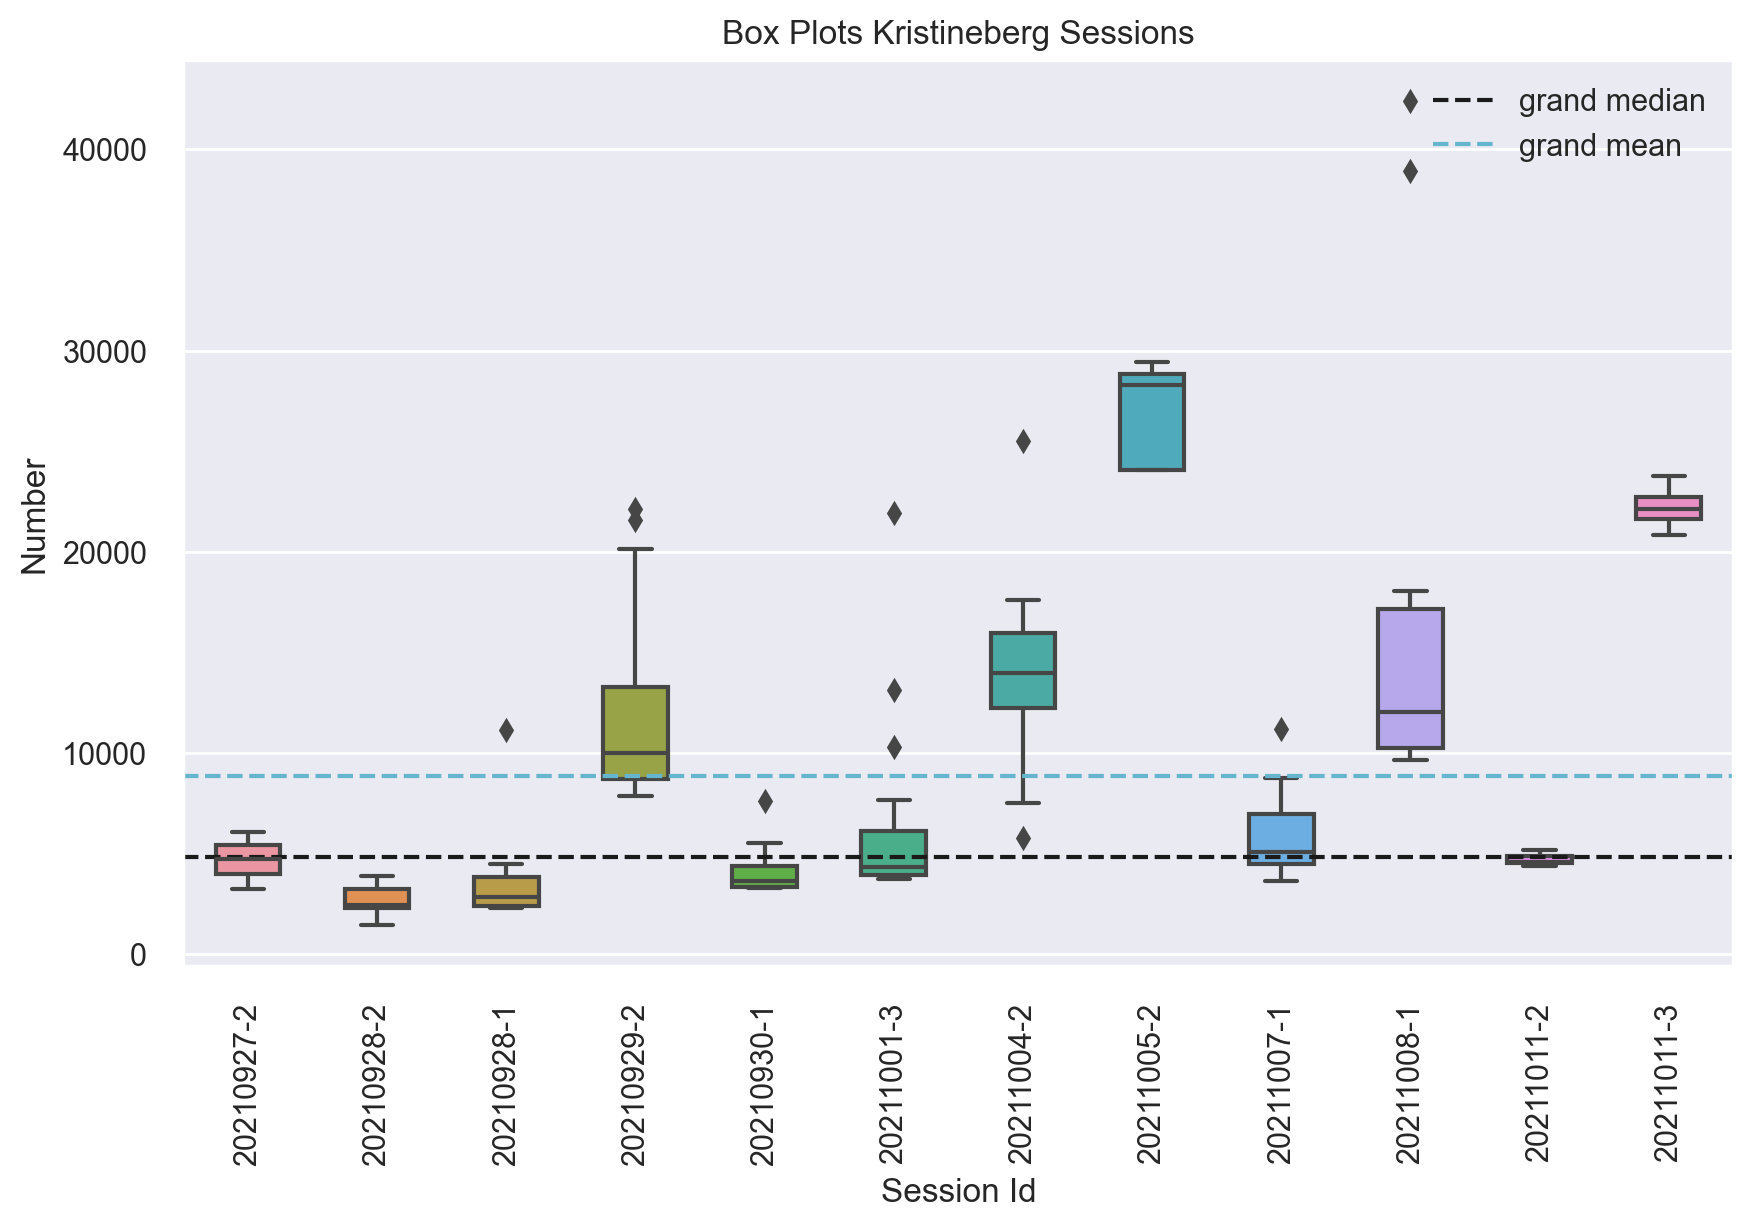

In [54]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Session Id', y=param, data=focus_r_df.sort_values(by=['Timestamp']), width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.xticks(rotation=90)
plt.legend()
plt.title('Box Plots Kristineberg Sessions')
plt.savefig(f'{fig_folder}/Kristineberg_box_plot_sessions({param}).pdf')
plt.show()

### Distribution

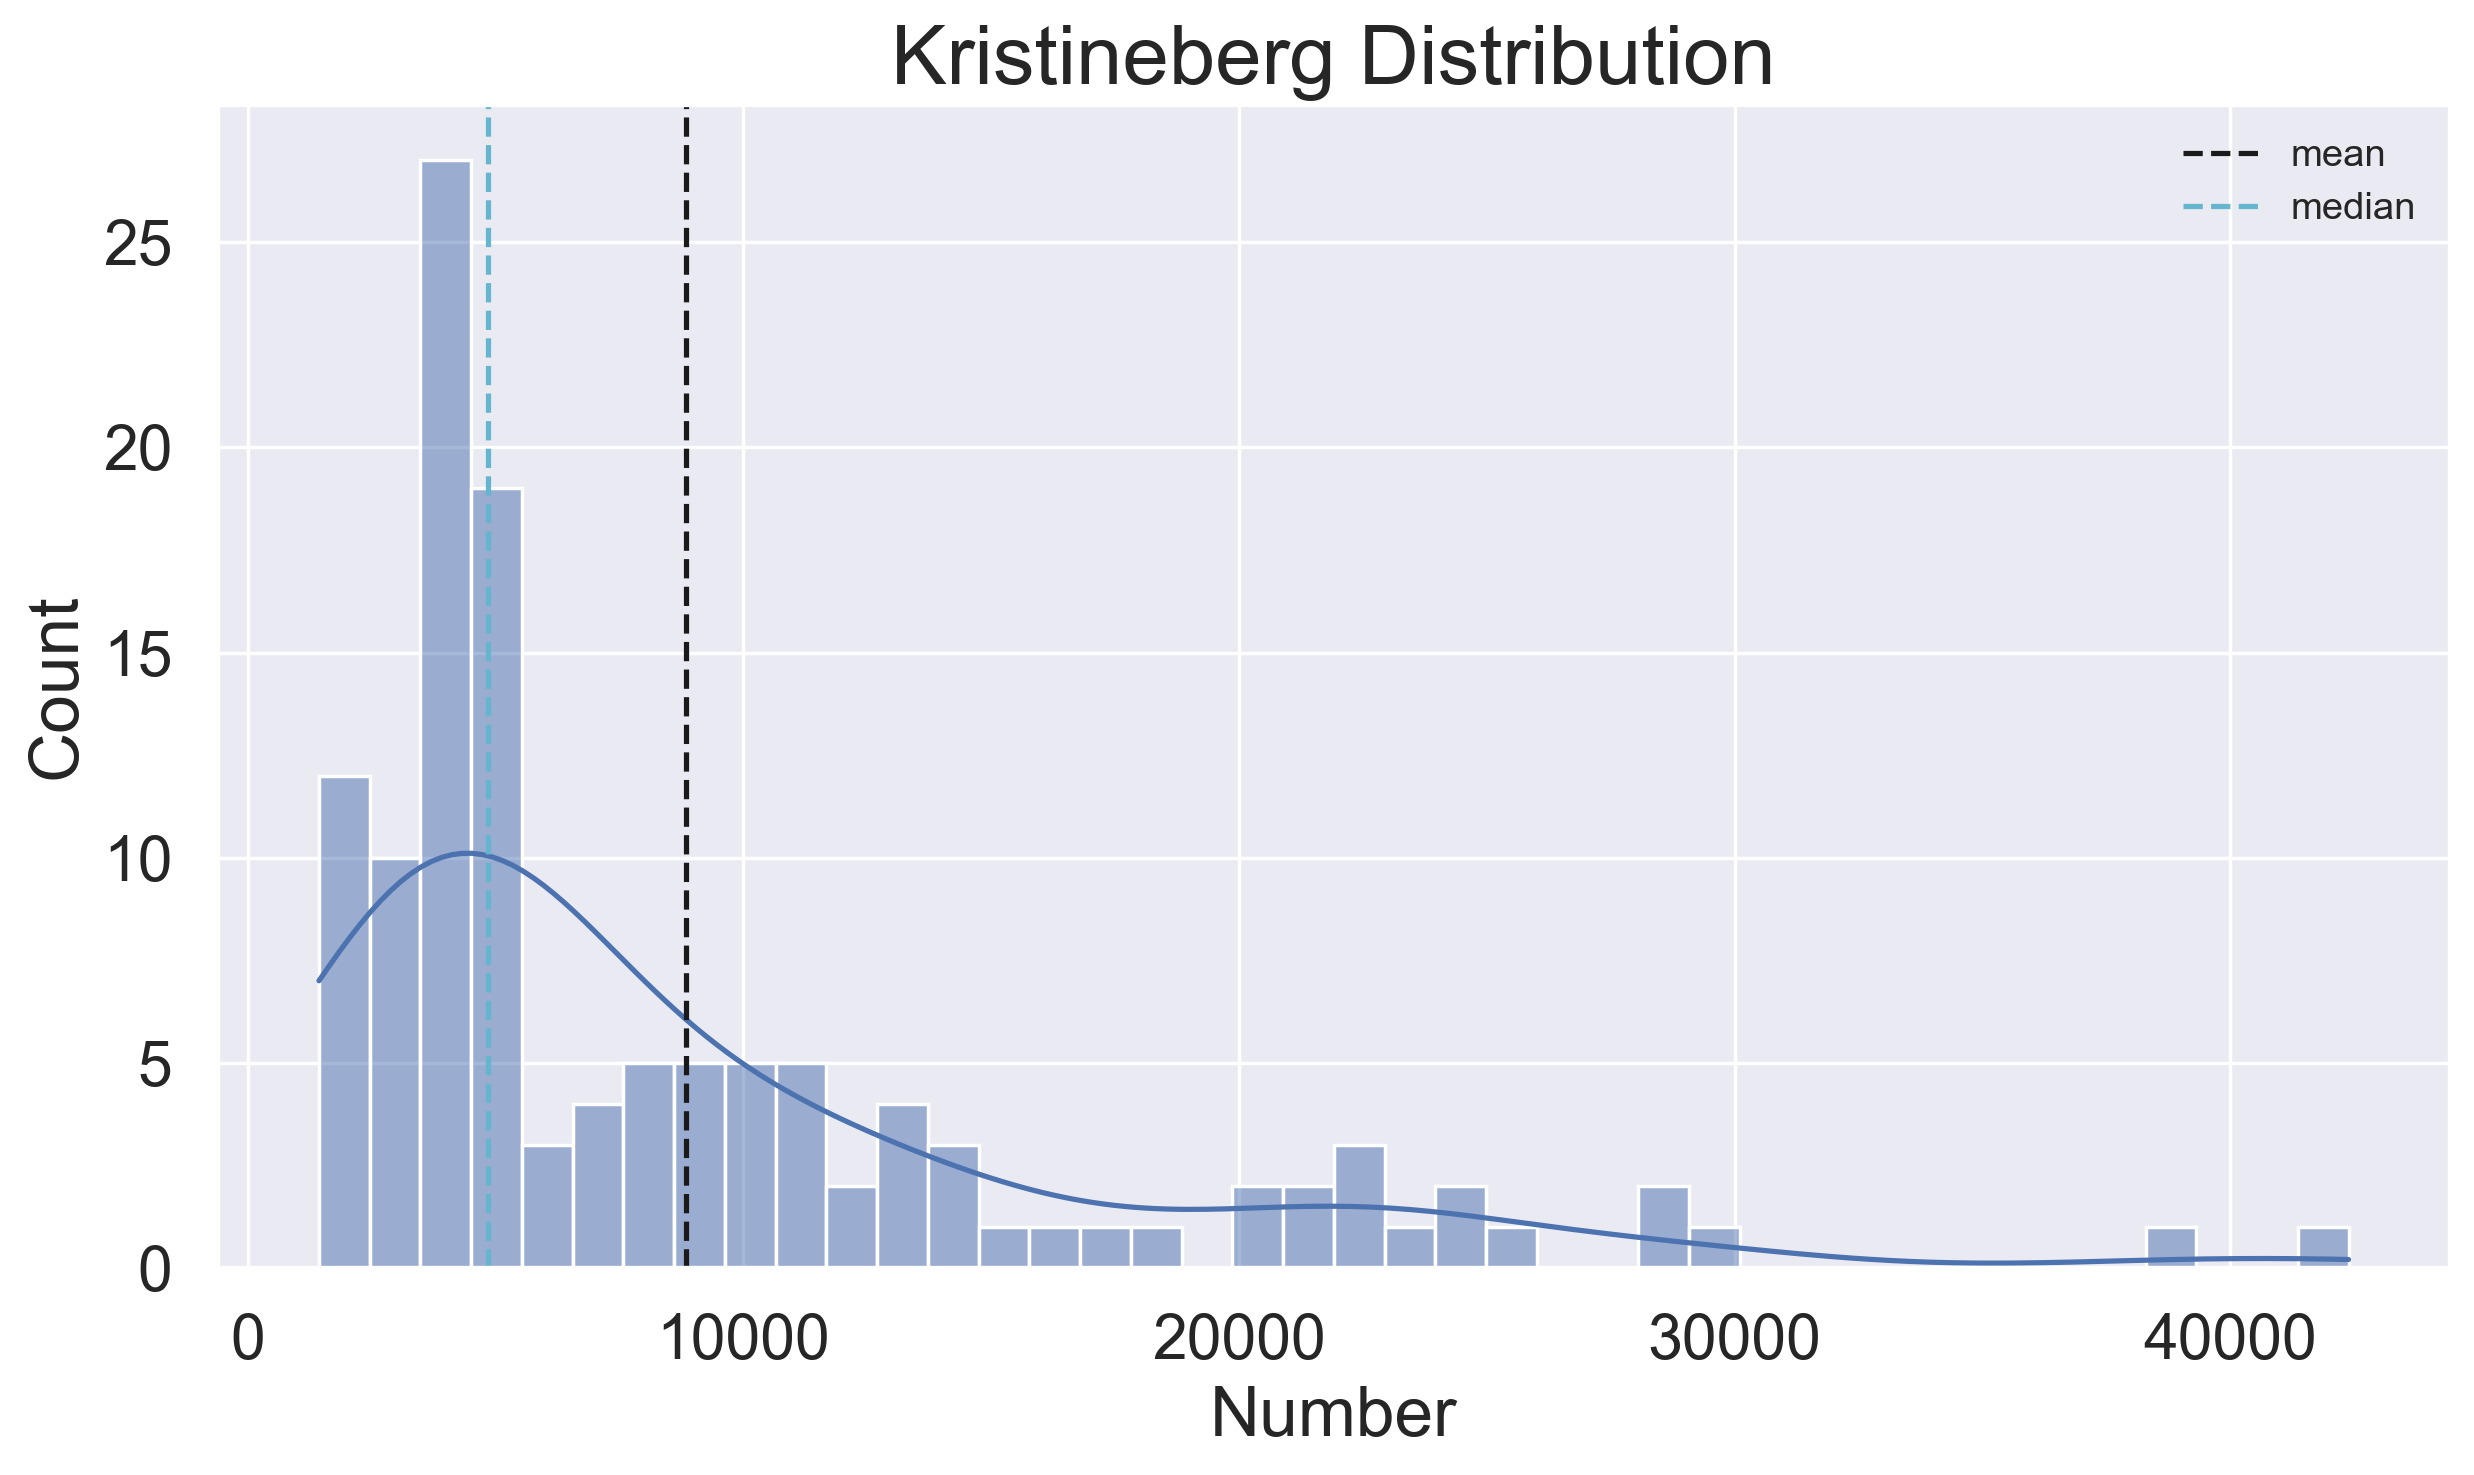

In [55]:
fig, ax = plt.subplots(dpi=250, figsize=[10, 6])

mean = focus_r_df[param].mean()
median = focus_r_df[param].median()
std = sample_std(focus_r_df[param].values)
s_skew = stats.skew(focus_r_df[param], bias=False)
s_kurt = stats.kurtosis(focus_r_df[param], bias=False)

sns.histplot(focus_r_df, x=param, kde=True, bins=40)

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)

ax.set_xlabel(param, fontsize=20)
ax.set_ylabel("Count", fontsize=20)
ax.set_title(f"Kristineberg Distribution", fontsize=24)

ax.axvline(mean, c="k", linestyle="--", label="mean")
ax.axvline(median, c="c", linestyle="--", label="median")
ax.legend()
plt.tight_layout()

plt.savefig(f'{fig_folder}/KristinebergDistribution({param}).pdf')

plt.show()

## Focus on Hötorget

In [56]:
focus_s_df = s_df.loc[s_df.Station == 'Hötorget'].sort_values(by=['Timestamp'])
focus_r_df = r_df.loc[r_df.Station == 'Hötorget'].sort_values(by=['Sensor'])

### Box plot sessions

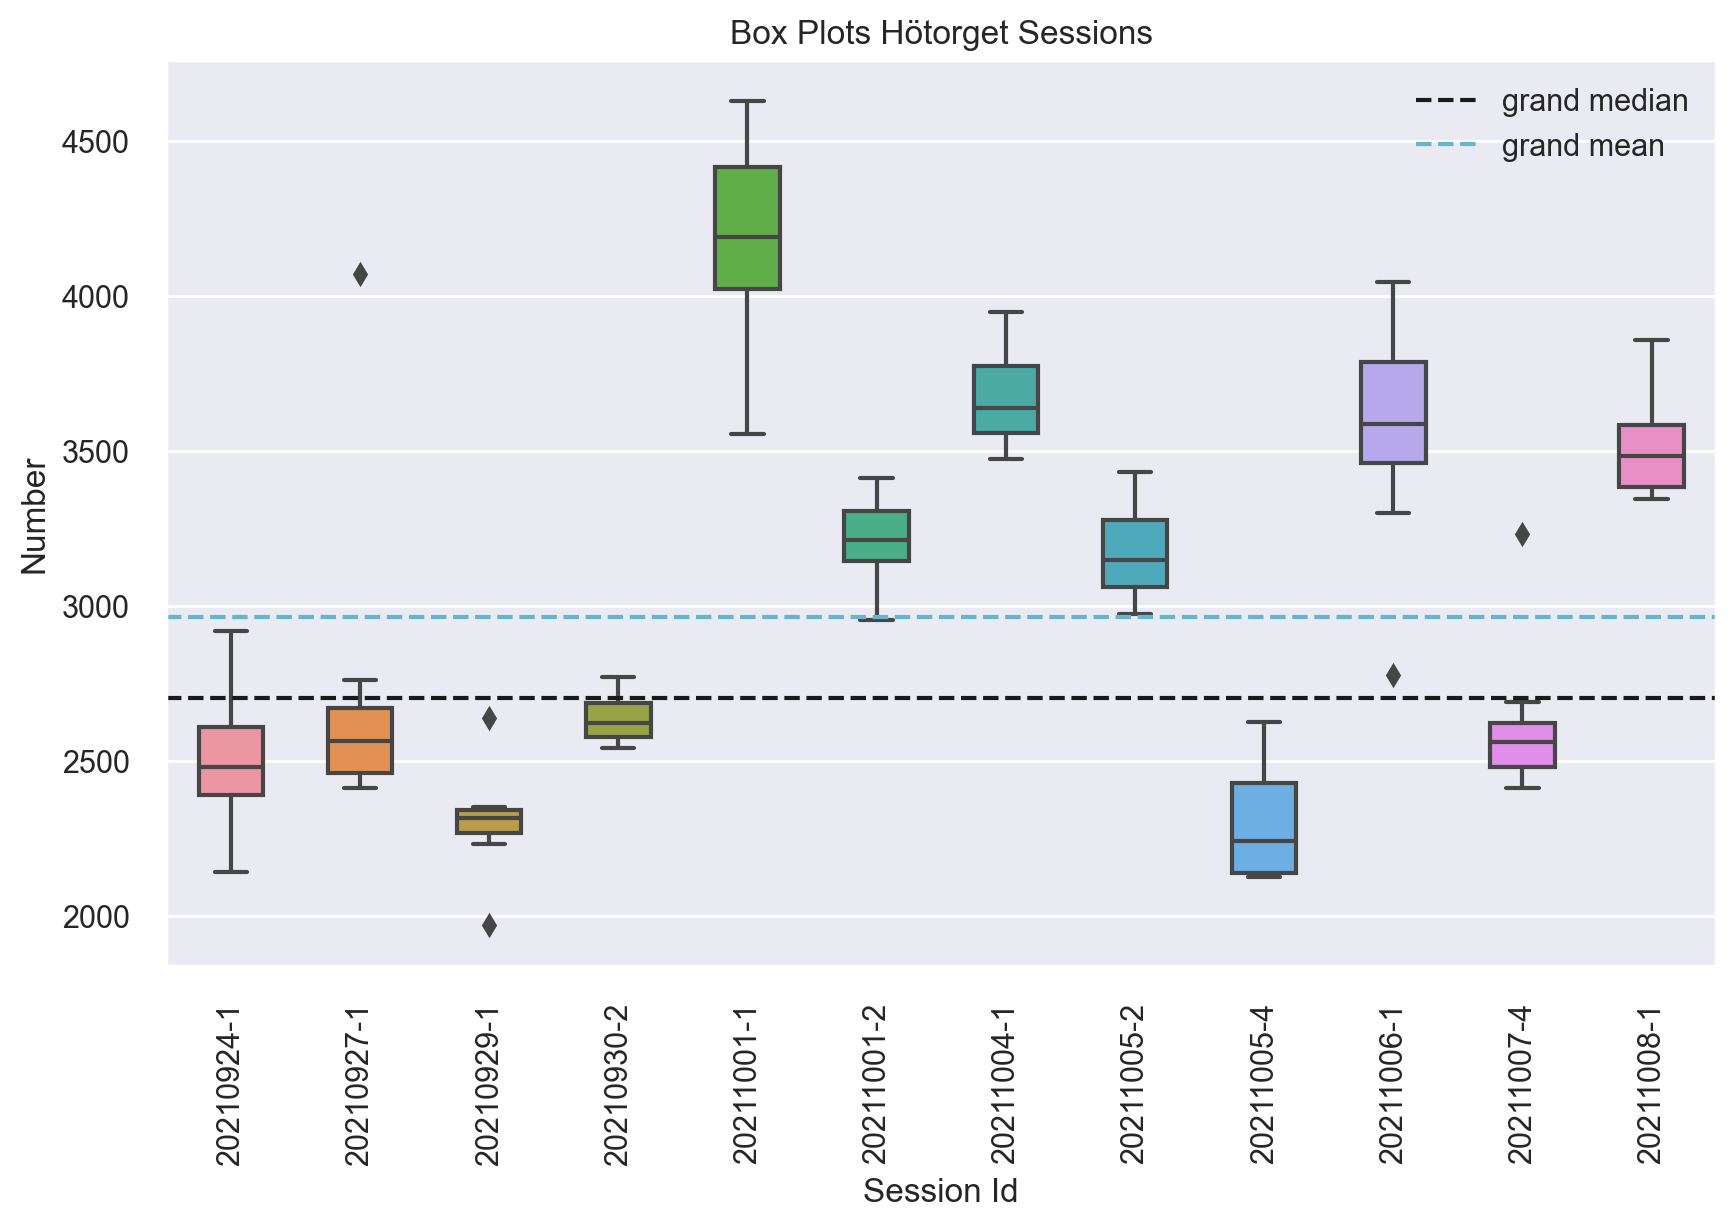

In [57]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Session Id', y=param, data=focus_r_df.sort_values(by=['Timestamp']), width=0.5)

plt.axhline(focus_r_df[param].median(), c='k', linestyle='--', label='grand median')
plt.axhline(focus_r_df[param].mean(), c='c', linestyle='--', label='grand mean')

plt.xticks(rotation=90)
plt.legend()
plt.title('Box Plots Hötorget Sessions')
plt.savefig(f'{fig_folder}/Hötorget_box_plot_sessions({param}).pdf')
plt.show()

# Size distributions

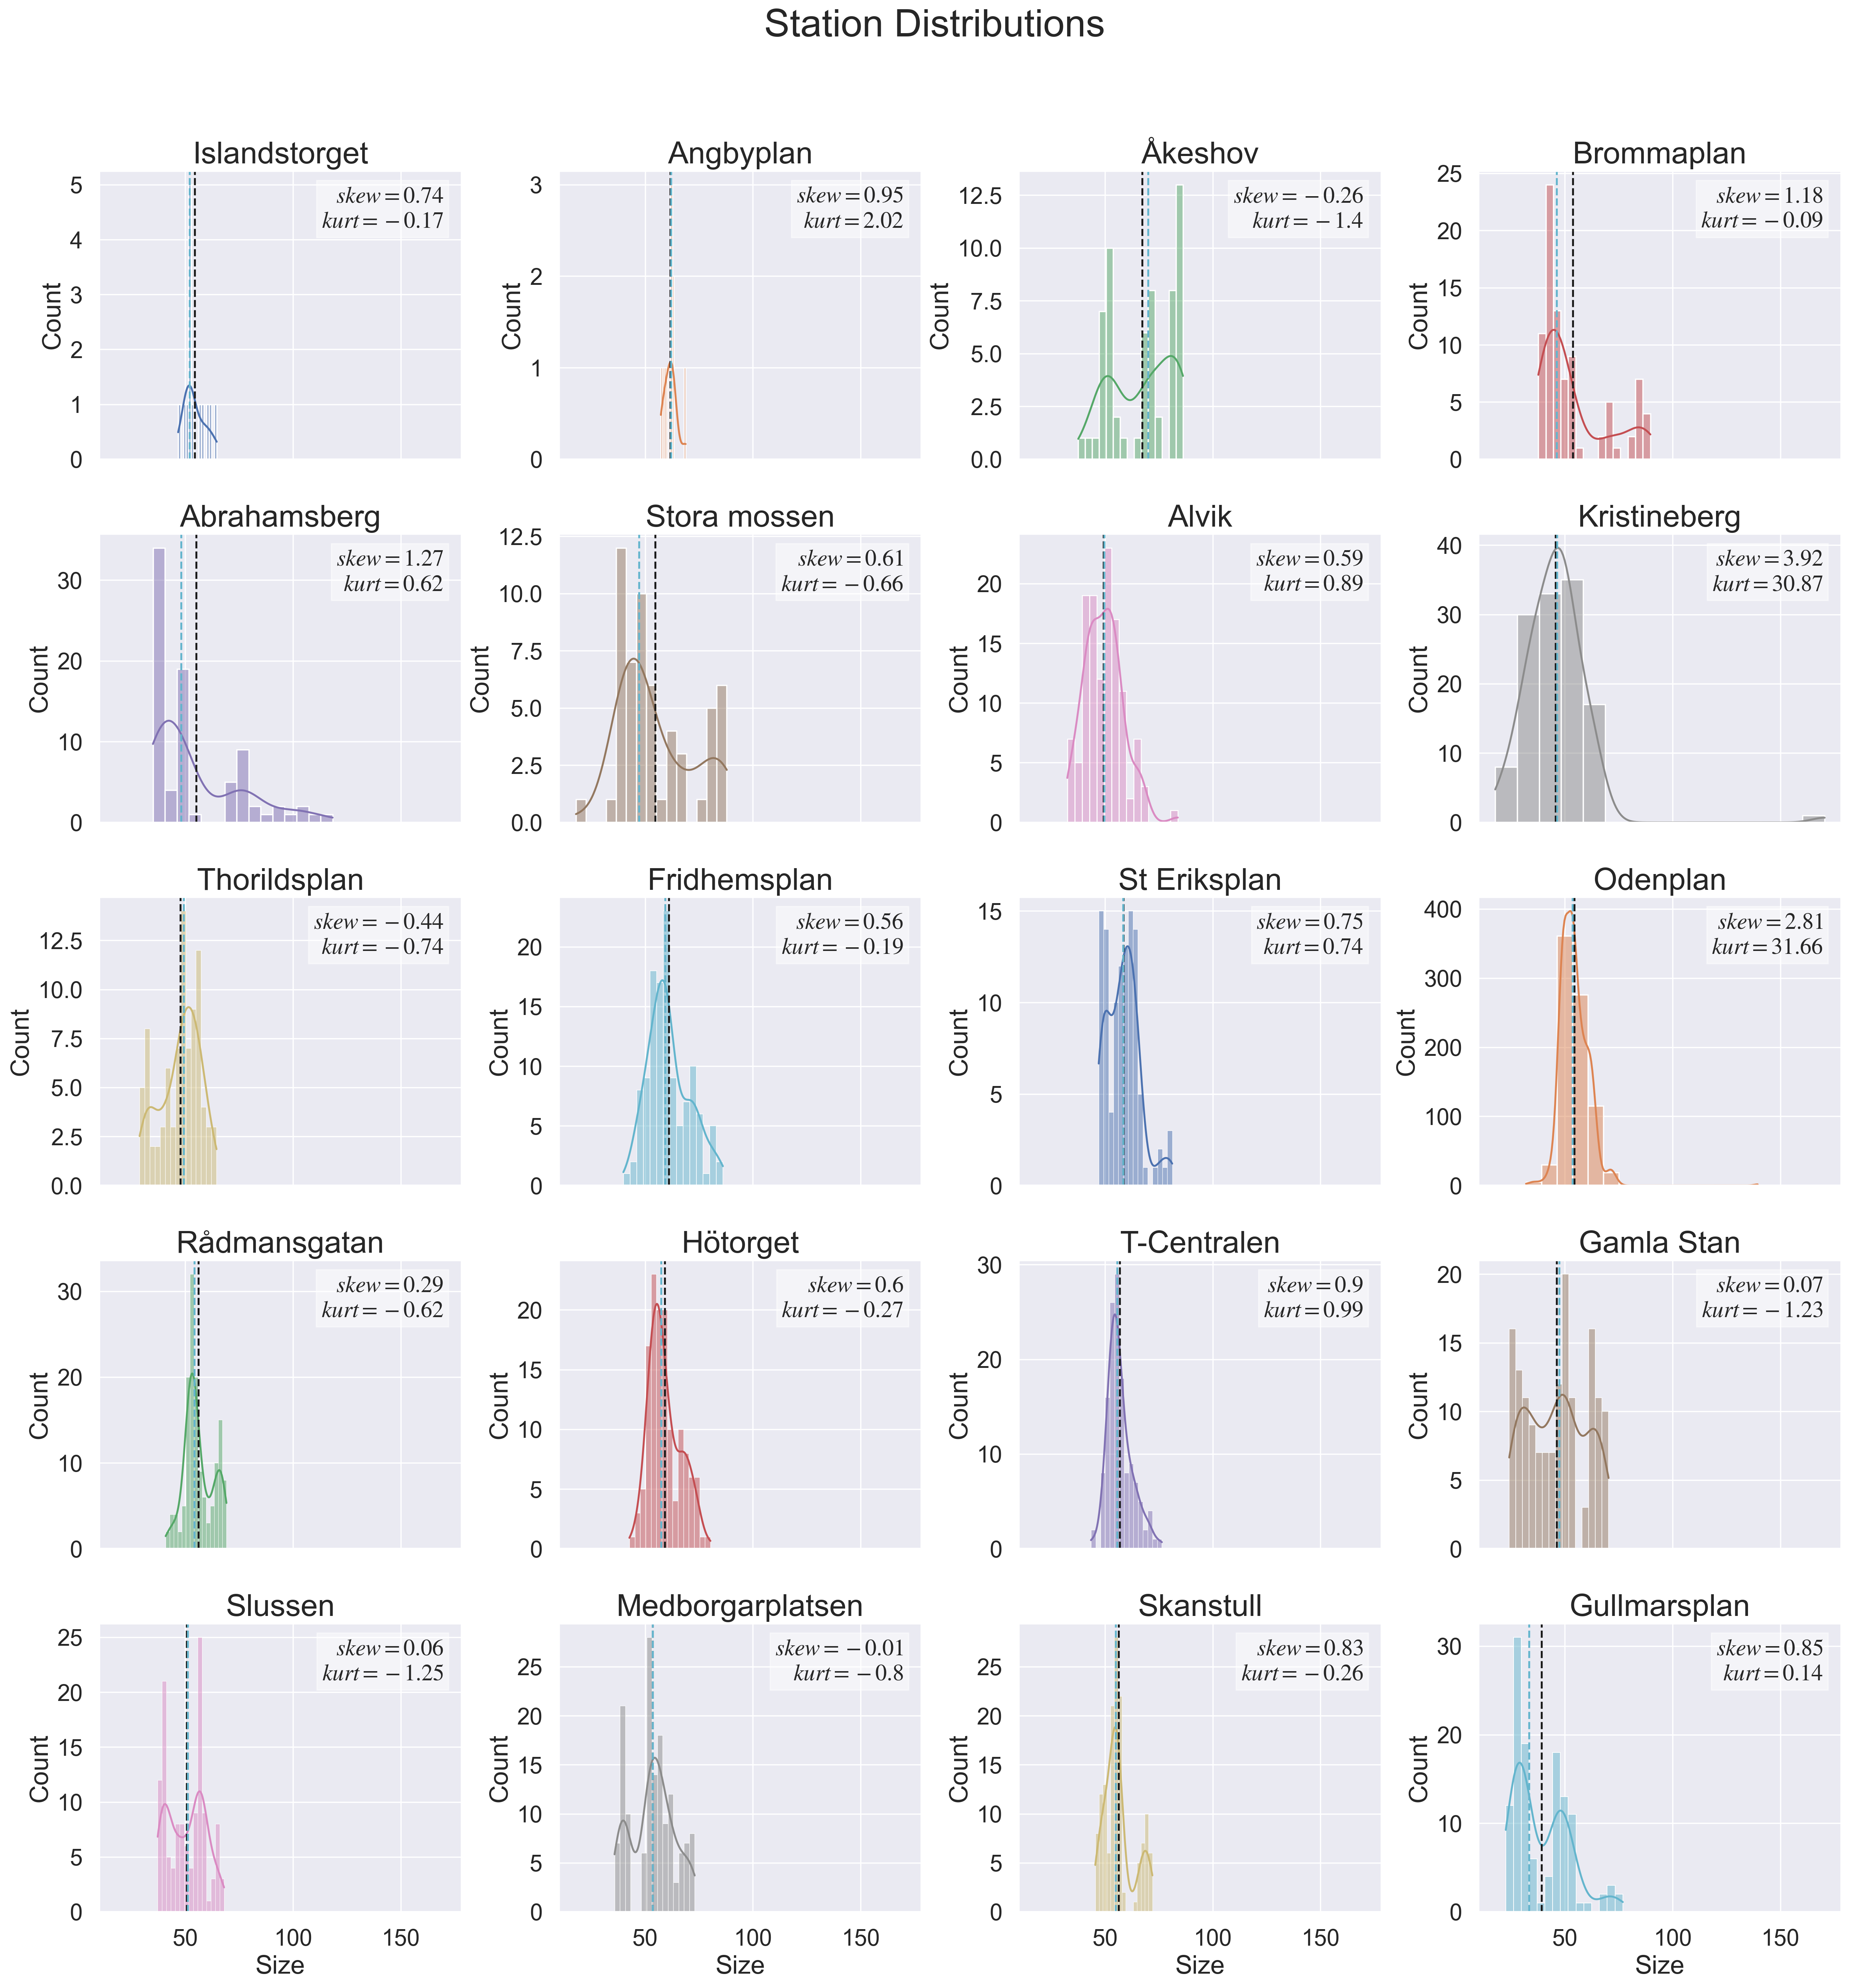

In [58]:
plot_distributions(
    df=r_df, 
    dist_col='Station', 
    title='Station Distributions', 
    fig_name=f'{fig_folder}/size_distribution({param}).pdf',
    param='Size',
    with_textbox=True,
    column_count=4,
    bins=15,
    share_x=True,
    share_y=False
)

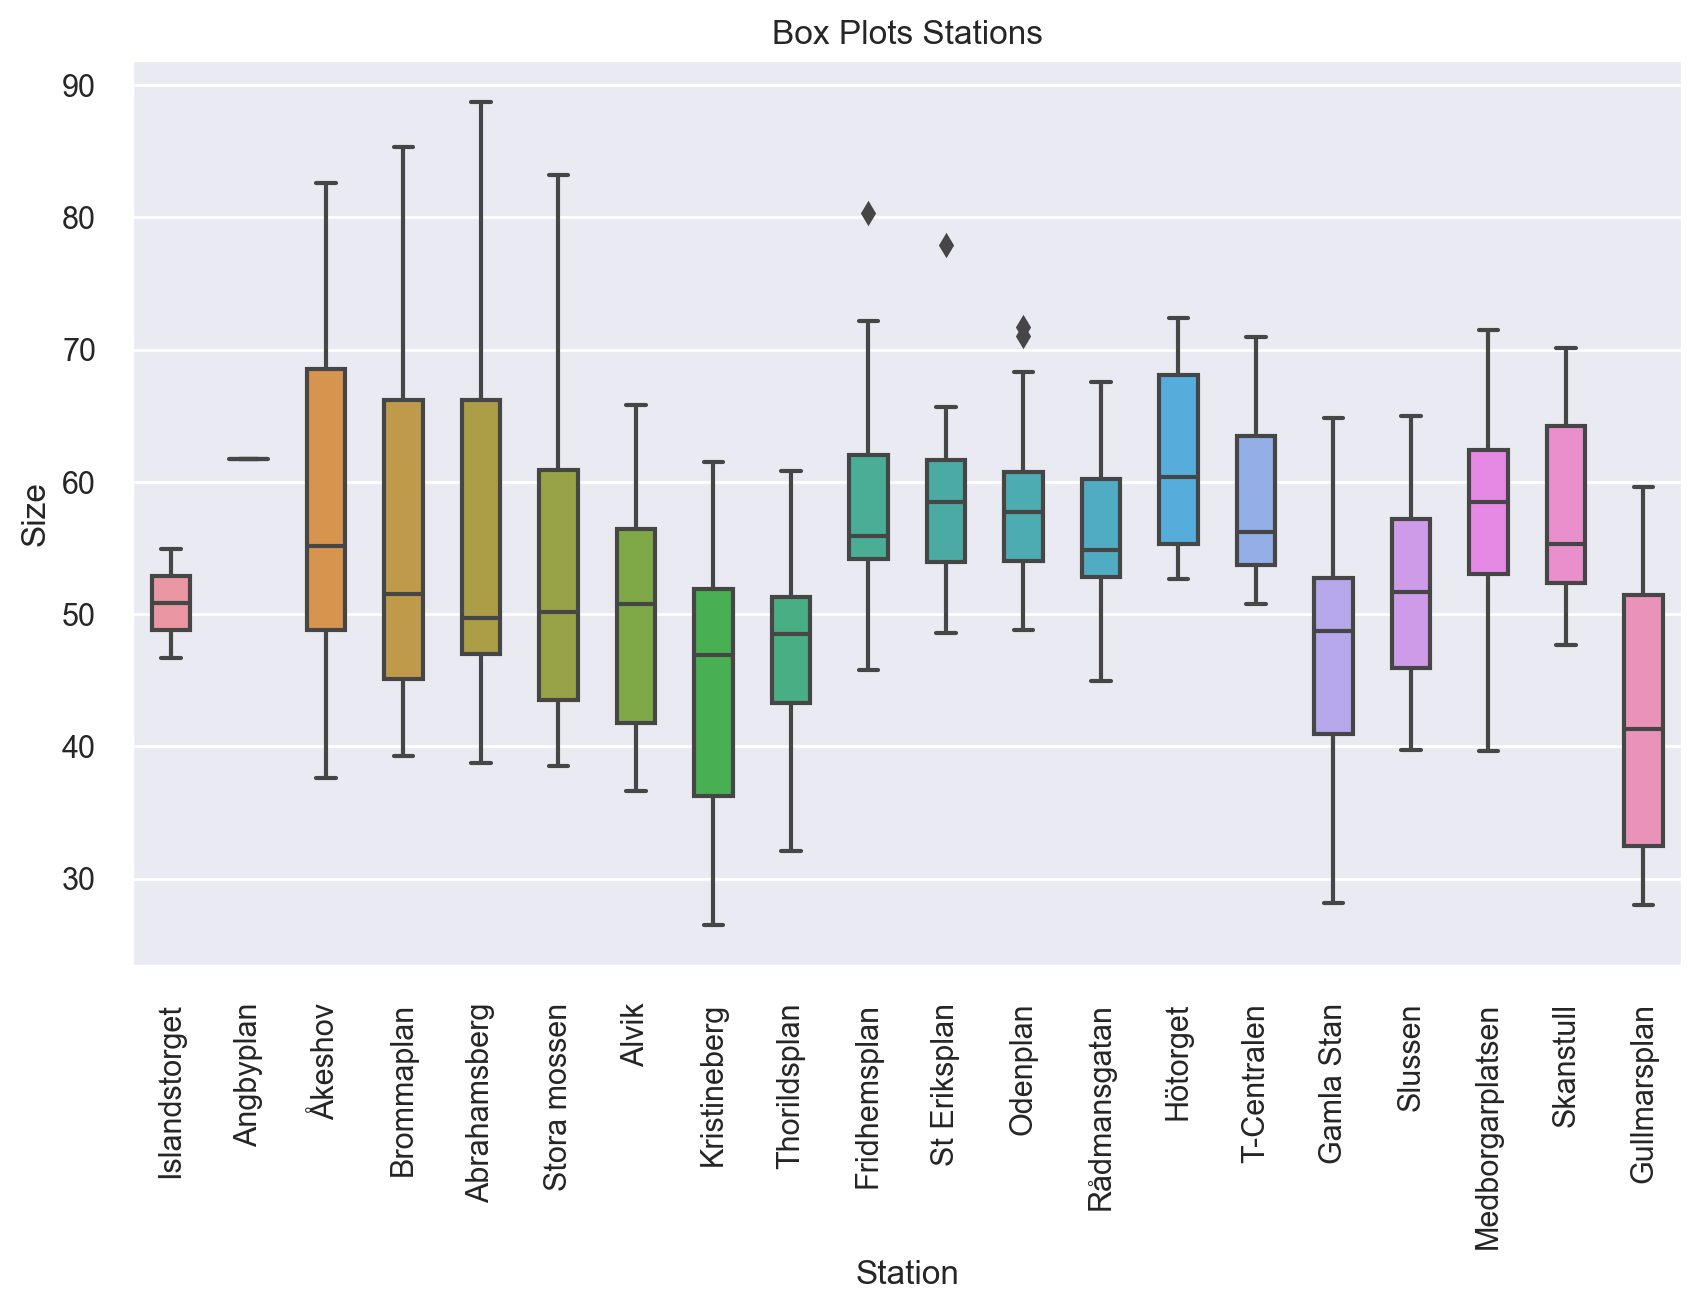

In [59]:
fig, ax = plt.subplots(figsize=[10,6], dpi=200)

sns.boxplot(x='Station', y='Size', data=s_df, width=0.5, order=get_green_line())
plt.xticks(rotation=90)
plt.title('Box Plots Stations')
plt.savefig(f'{fig_folder}/box_plots(Size).pdf')

plt.show()

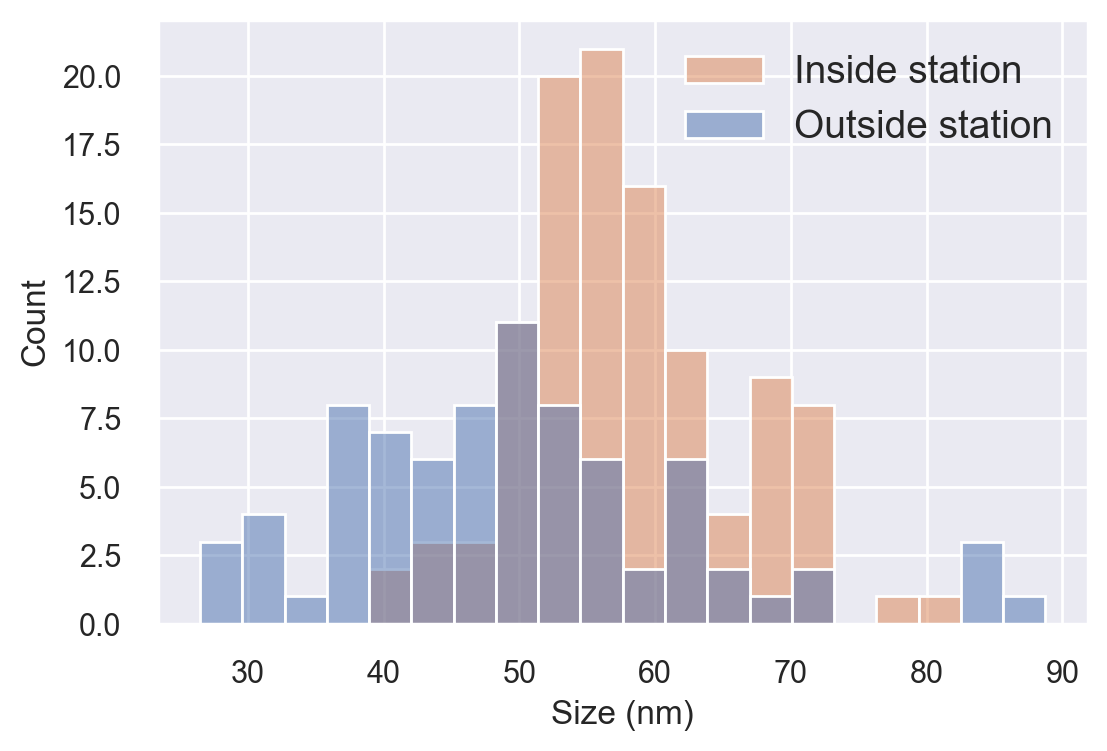

In [42]:
inside_stations = [
    'Fridhemsplan', 
    'St Eriksplan', 
    'Odenplan', 
    'Rådmansgatan', 
    'Hötorget', 
    'T-Centralen', 
    'Slussen', 
    'Medborgarplatsen',
    'Skanstull'
]

dist_df = s_df.copy()
dist_df['Inside'] = dist_df['Station'].apply(lambda x: x in inside_stations)

fig, ax = plt.subplots(figsize=[6,4], dpi=200)

sns.histplot(dist_df, x='Size', hue='Inside', kde=False, bins=20)
#sns.histplot(dist_df, x='PM2.5', hue='Inside', kde=False, bins=20)
#sns.displot(dist_df, x='TypicalParticleSize', hue='Inside', kind='kde', multiple='stack')
plt.legend(['Inside station', 'Outside station'], fontsize=14)
plt.ylabel('Count')
plt.xlabel('Size (nm)')

plt.savefig(f'{fig_folder}/DistPlotSize({param}).pdf', dpi=300, bbox_inches="tight")

plt.show()

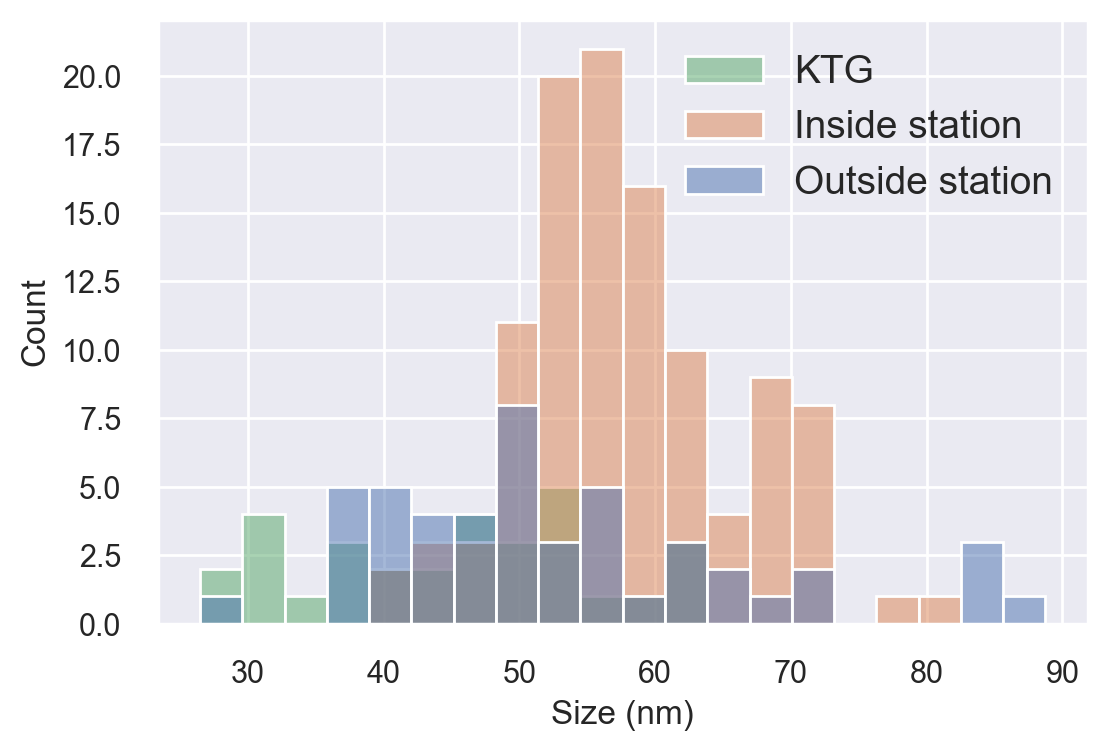

In [51]:
inside_stations = [
    'Fridhemsplan', 
    'St Eriksplan', 
    'Odenplan', 
    'Rådmansgatan', 
    'Hötorget', 
    'T-Centralen', 
    'Slussen', 
    'Medborgarplatsen',
    'Skanstull'
]

focus = [
    'Kristineberg',
    'Thorildsplan',
    'Gullmarsplan'
]

dist_df = s_df.copy()
dist_df['Inside'] = dist_df['Station'].apply(lambda x: 'KTG' if x in focus else '2' if x in inside_stations else '1')
dist_df = dist_df.sort_values(by=['Inside'])
fig, ax = plt.subplots(figsize=[6,4], dpi=200)

sns.histplot(dist_df, x='Size', hue='Inside', kde=False, bins=20)
#sns.histplot(dist_df, x='PM2.5', hue='Inside', kde=False, bins=20)
#sns.displot(dist_df, x='TypicalParticleSize', hue='Inside', kind='kde', multiple='stack')
plt.legend(['KTG','Inside station', 'Outside station'], fontsize=14)
plt.ylabel('Count')
plt.xlabel('Size (nm)')

plt.savefig(f'{fig_folder}/DistPlotSizeFocus1({param}).pdf', dpi=300, bbox_inches="tight")

plt.show()

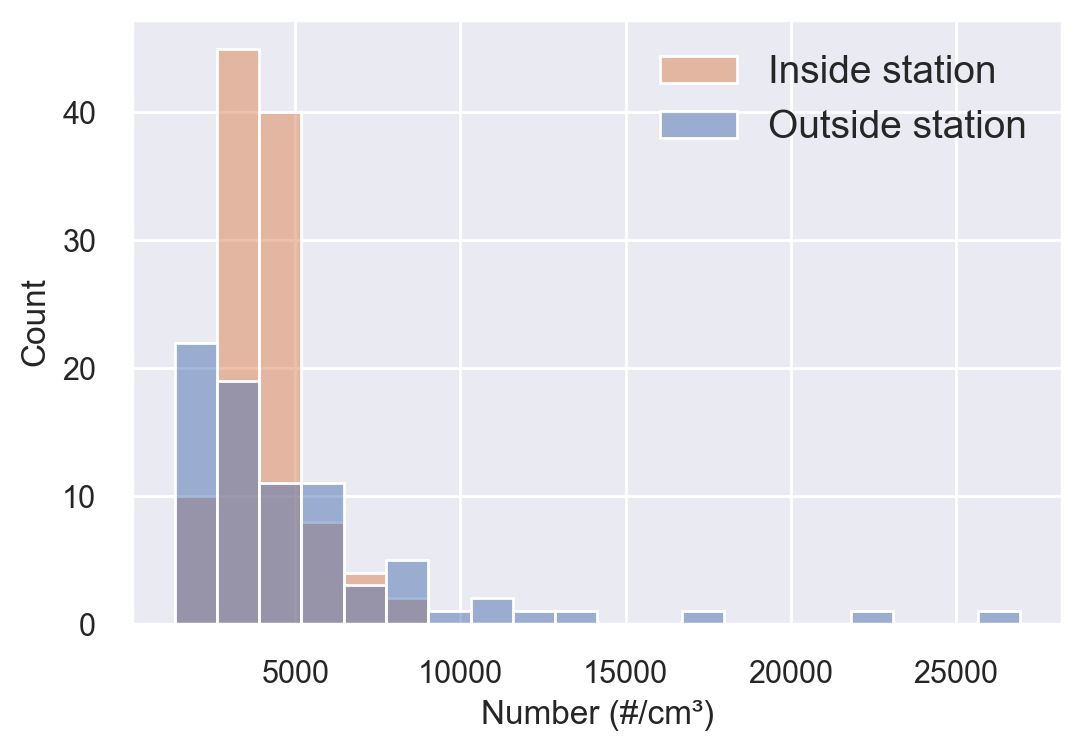

In [36]:
inside_stations = [
    'Fridhemsplan', 
    'St Eriksplan', 
    'Odenplan', 
    'Rådmansgatan', 
    'Hötorget', 
    'T-Centralen', 
    'Slussen', 
    'Medborgarplatsen',
    'Skanstull'
]



dist_df = s_df.copy()
dist_df['Inside'] = dist_df['Station'].apply(lambda x: '2' if x in inside_stations else '1')

fig, ax = plt.subplots(figsize=[6,4], dpi=200)

sns.histplot(dist_df, x=param, hue='Inside', kde=False, bins=20)
#sns.histplot(dist_df, x='PM2.5', hue='Inside', kde=False, bins=20)
#sns.displot(dist_df, x='TypicalParticleSize', hue='Inside', kind='kde', multiple='stack')
plt.legend(['Inside station', 'Outside station'], fontsize=14)
plt.ylabel('Count')
plt.xlabel(f'{param} ({unit})')

plt.savefig(f'{fig_folder}/DistPlotNumber({param}).pdf', dpi=300, bbox_inches="tight")

plt.show()

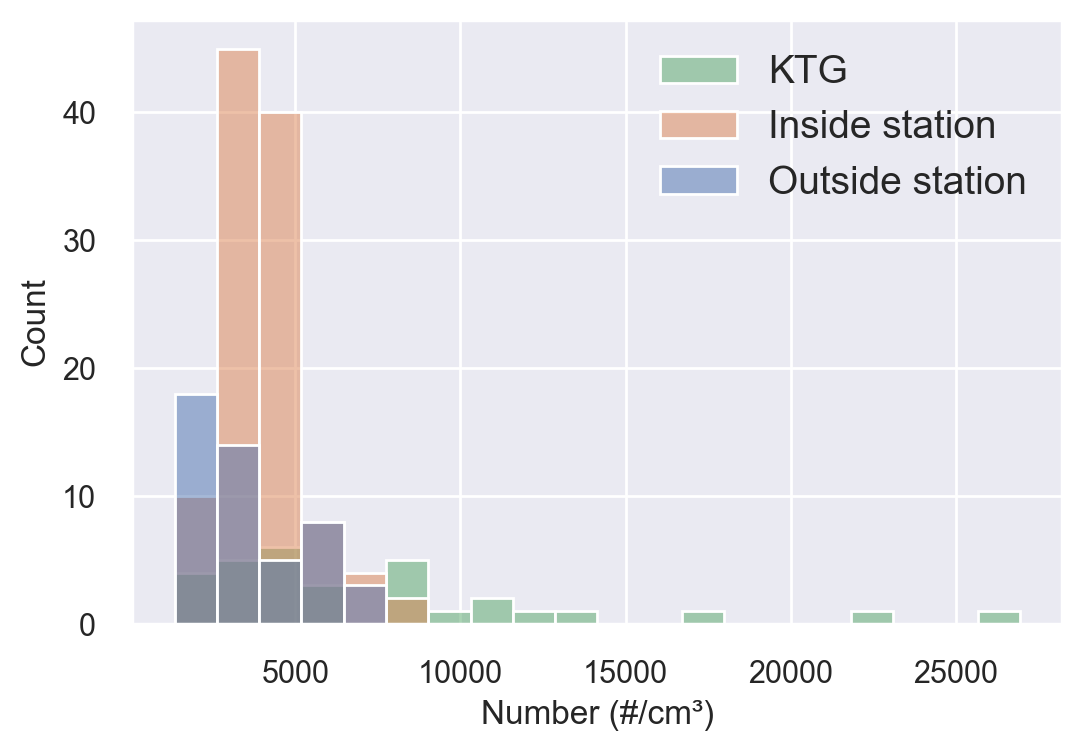

In [35]:
inside_stations = [
    'Fridhemsplan', 
    'St Eriksplan', 
    'Odenplan', 
    'Rådmansgatan', 
    'Hötorget', 
    'T-Centralen', 
    'Slussen', 
    'Medborgarplatsen',
    'Skanstull'
]

focus = [
    'Kristineberg',
    'Thorildsplan',
    'Gullmarsplan'
]

dist_df = s_df.copy()
dist_df['Inside'] = dist_df['Station'].apply(lambda x: 'KTG' if x in focus else '2' if x in inside_stations else '1')
dist_df = dist_df.sort_values(by=['Inside'])

fig, ax = plt.subplots(figsize=[6,4], dpi=200)

sns.histplot(dist_df, x=param, hue='Inside', kde=False, bins=20)
#sns.histplot(dist_df, x='PM2.5', hue='Inside', kde=False, bins=20)
#sns.displot(dist_df, x='TypicalParticleSize', hue='Inside', kind='kde', multiple='stack')
plt.legend(['KTG', 'Inside station', 'Outside station'], fontsize=14)
plt.ylabel('Count')
plt.xlabel(f'{param} ({unit})')

plt.savefig(f'{fig_folder}/DistPlotNumberFocus({param}).pdf', dpi=300, bbox_inches="tight")

plt.show()

### By Size

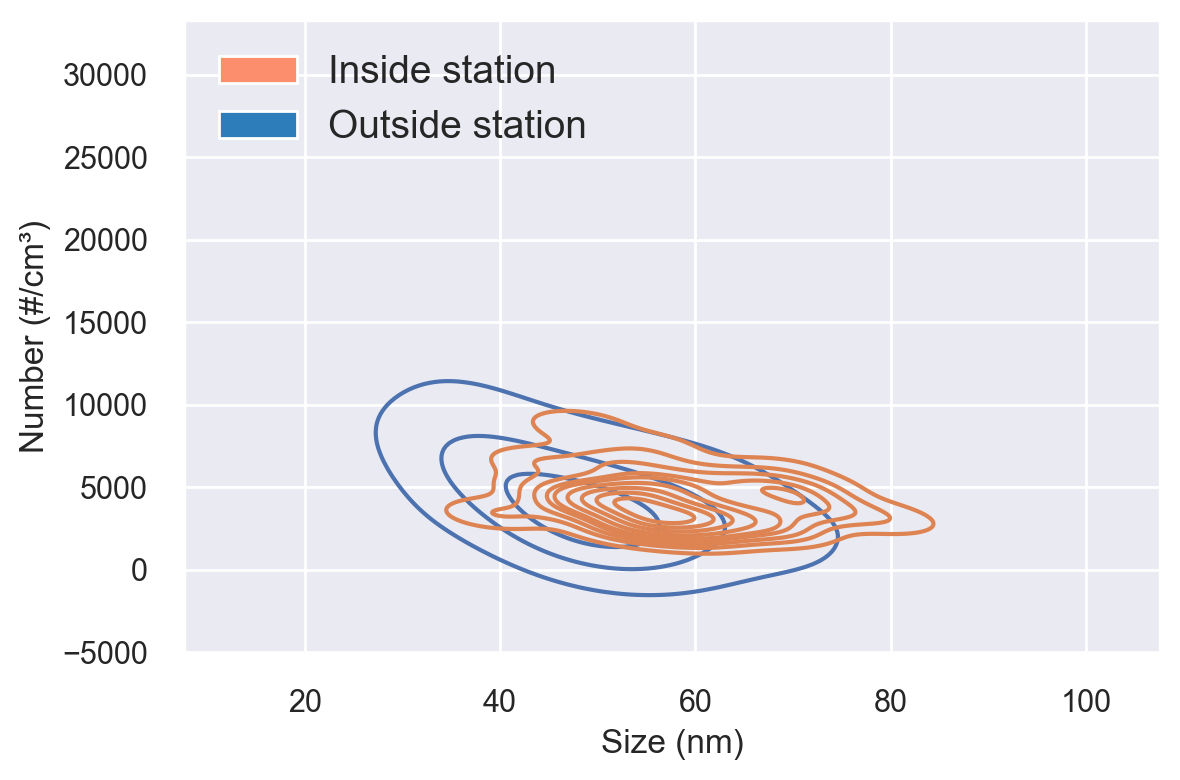

In [63]:
import matplotlib.patches as  mpatches

fig, ax = plt.subplots(figsize=[6,4], dpi=200)

station_labels = ['Inside station', 'Outside station']
g = sns.kdeplot(data=dist_df, x='Size', y=param, hue='Inside', shade=False)

plt.legend(['Inside station', 'Outside station'], fontsize=14)
plt.xlabel('Size (nm)')
plt.ylabel(f'{param} ({unit})')

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="Inside station"),
           mpatches.Patch(facecolor=plt.cm.Blues(180), label="Outside station")]

plt.legend(handles=handles, loc=2, fontsize=14)

plt.tight_layout()

plt.savefig(f'{fig_folder}/KdePlotSize{param}Shade.pdf', dpi=300, bbox_inches="tight")

plt.show(g)

## By size 2

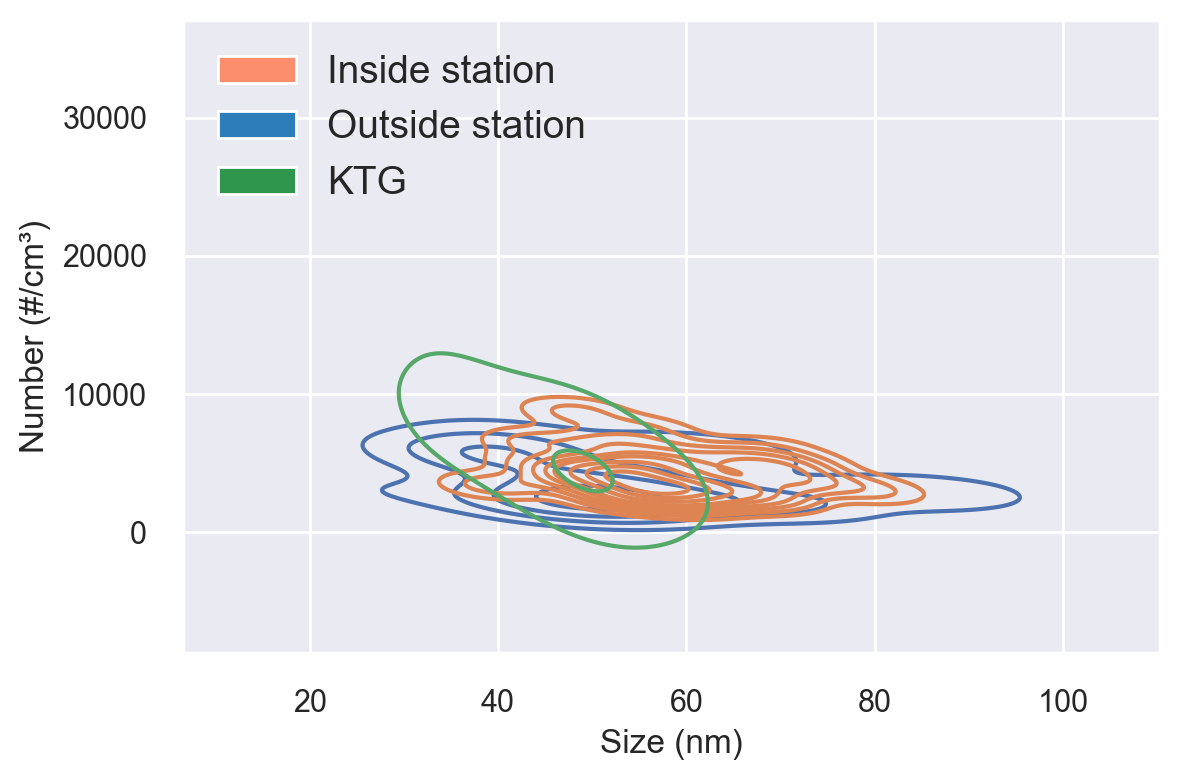

In [41]:
import matplotlib.patches as  mpatches

fig, ax = plt.subplots(figsize=[6,4], dpi=200)

dist_df = s_df.copy()
dist_df['Inside'] = dist_df['Station'].apply(lambda x: 'KTG' if x in focus else '2' if x in inside_stations else '1')
dist_df = dist_df.sort_values(by=['Inside'])

#station_labels = ['', 'Inside station', 'Outside station']
g = sns.kdeplot(data=dist_df, x='Size', y=param, hue='Inside', shade=False)


#plt.legend(['Inside station', 'Outside station'], fontsize=14)
plt.xlabel('Size (nm)')
plt.ylabel(f'{param} ({unit})')

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="Inside station"),
           mpatches.Patch(facecolor=plt.cm.Blues(180), label="Outside station"),
          mpatches.Patch(facecolor=plt.cm.Greens(180), label="KTG")]

plt.legend(handles=handles, loc=2, fontsize=14)

plt.tight_layout()

plt.savefig(f'{fig_folder}/KdePlotSizeFocus{param}Shade.pdf', dpi=300, bbox_inches="tight")

plt.show(g)

In [19]:
dist_df2.head(3)

Session Id            Timestamp        Period        Station Sensors  \
22  20210927-2  2021-09-27 18:33:38       Offtime  Islandstorget    DiSC   
40  20210928-2  2021-09-28 07:05:40  Morning rush  Islandstorget    DiSC   
66  20210930-1  2021-09-30 07:09:44  Morning rush      Angbyplan    DiSC   

         Number       Size      LDSA    Filter      Diff        Date  \
22  2121.923077  54.938462  6.453846  5.320000  2.356923  2021-09-27   
40  2059.000000  46.700000  5.330000  4.160000  2.180000  2021-09-28   
66  2292.000000  61.700000  8.052727  6.914545  2.664545  2021-09-30   

   Clock Time    Time  Station Order  Inside  Focus  
22   18:33:38  3884.5  Islandstorget   False  False  
40   07:05:40     4.5  Islandstorget   False  False  
66   07:09:44   114.5      Angbyplan   False  False

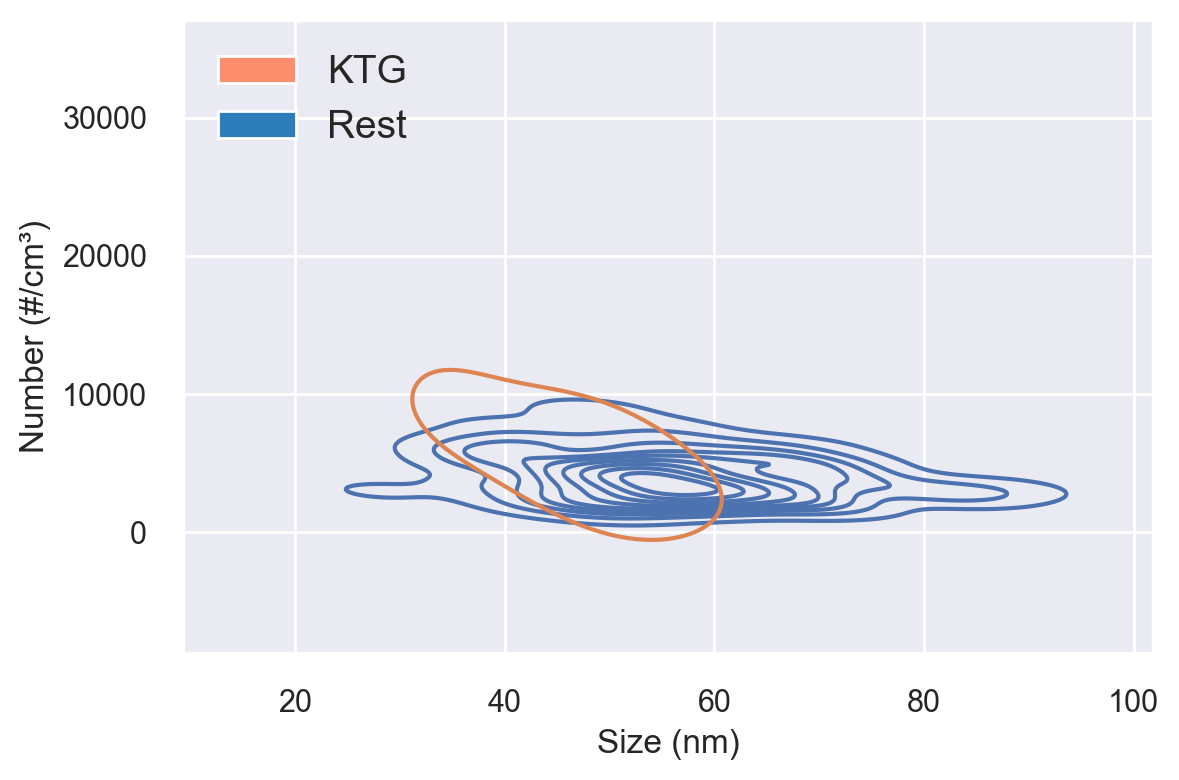

In [25]:
import matplotlib.patches as  mpatches

fig, ax = plt.subplots(figsize=[6,4], dpi=200)

station_labels = ['Inside station', 'Outside station']
g = sns.kdeplot(data=dist_df2, x='Size', y=param, hue='Focus', shade=False)

plt.legend(['Inside station', 'Outside station'], fontsize=14)
plt.xlabel('Size (nm)')
plt.ylabel(f'{param} ({unit})')

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="KTG"),
           mpatches.Patch(facecolor=plt.cm.Blues(180), label="Rest")]

plt.legend(handles=handles, loc=2, fontsize=14)

plt.tight_layout()

plt.savefig(f'{fig_folder}/KdePlotSize_2{param}.pdf', dpi=300, bbox_inches="tight")

plt.show(g)

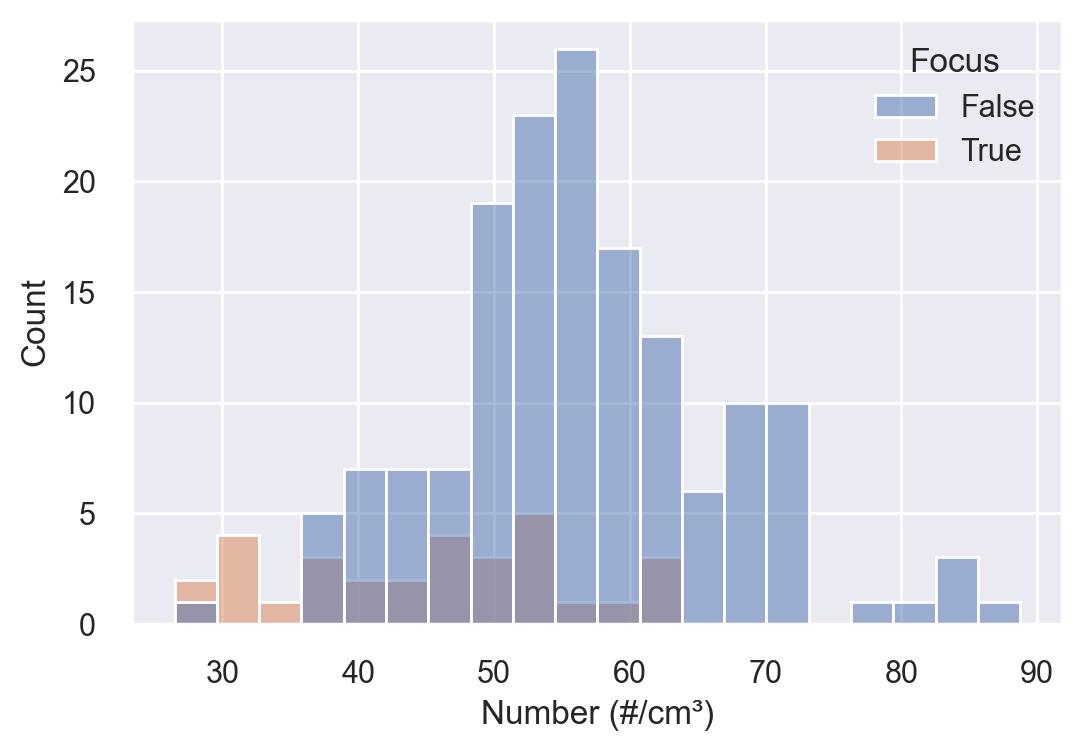

In [24]:
fig, ax = plt.subplots(figsize=[6,4], dpi=200)

sns.histplot(dist_df2, x='Size', hue='Focus', kde=False, bins=20)
#sns.histplot(dist_df, x='PM2.5', hue='Inside', kde=False, bins=20)
#sns.displot(dist_df, x='TypicalParticleSize', hue='Inside', kind='kde', multiple='stack')
#plt.legend(['Inside station', 'Outside station'], fontsize=14)
plt.ylabel('Count')
plt.xlabel(f'{param} ({unit})')

#plt.savefig(f'{fig_folder}/DistPlot({param}).pdf', dpi=300, bbox_inches="tight")

plt.show()

/opt/homebrew/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:793: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


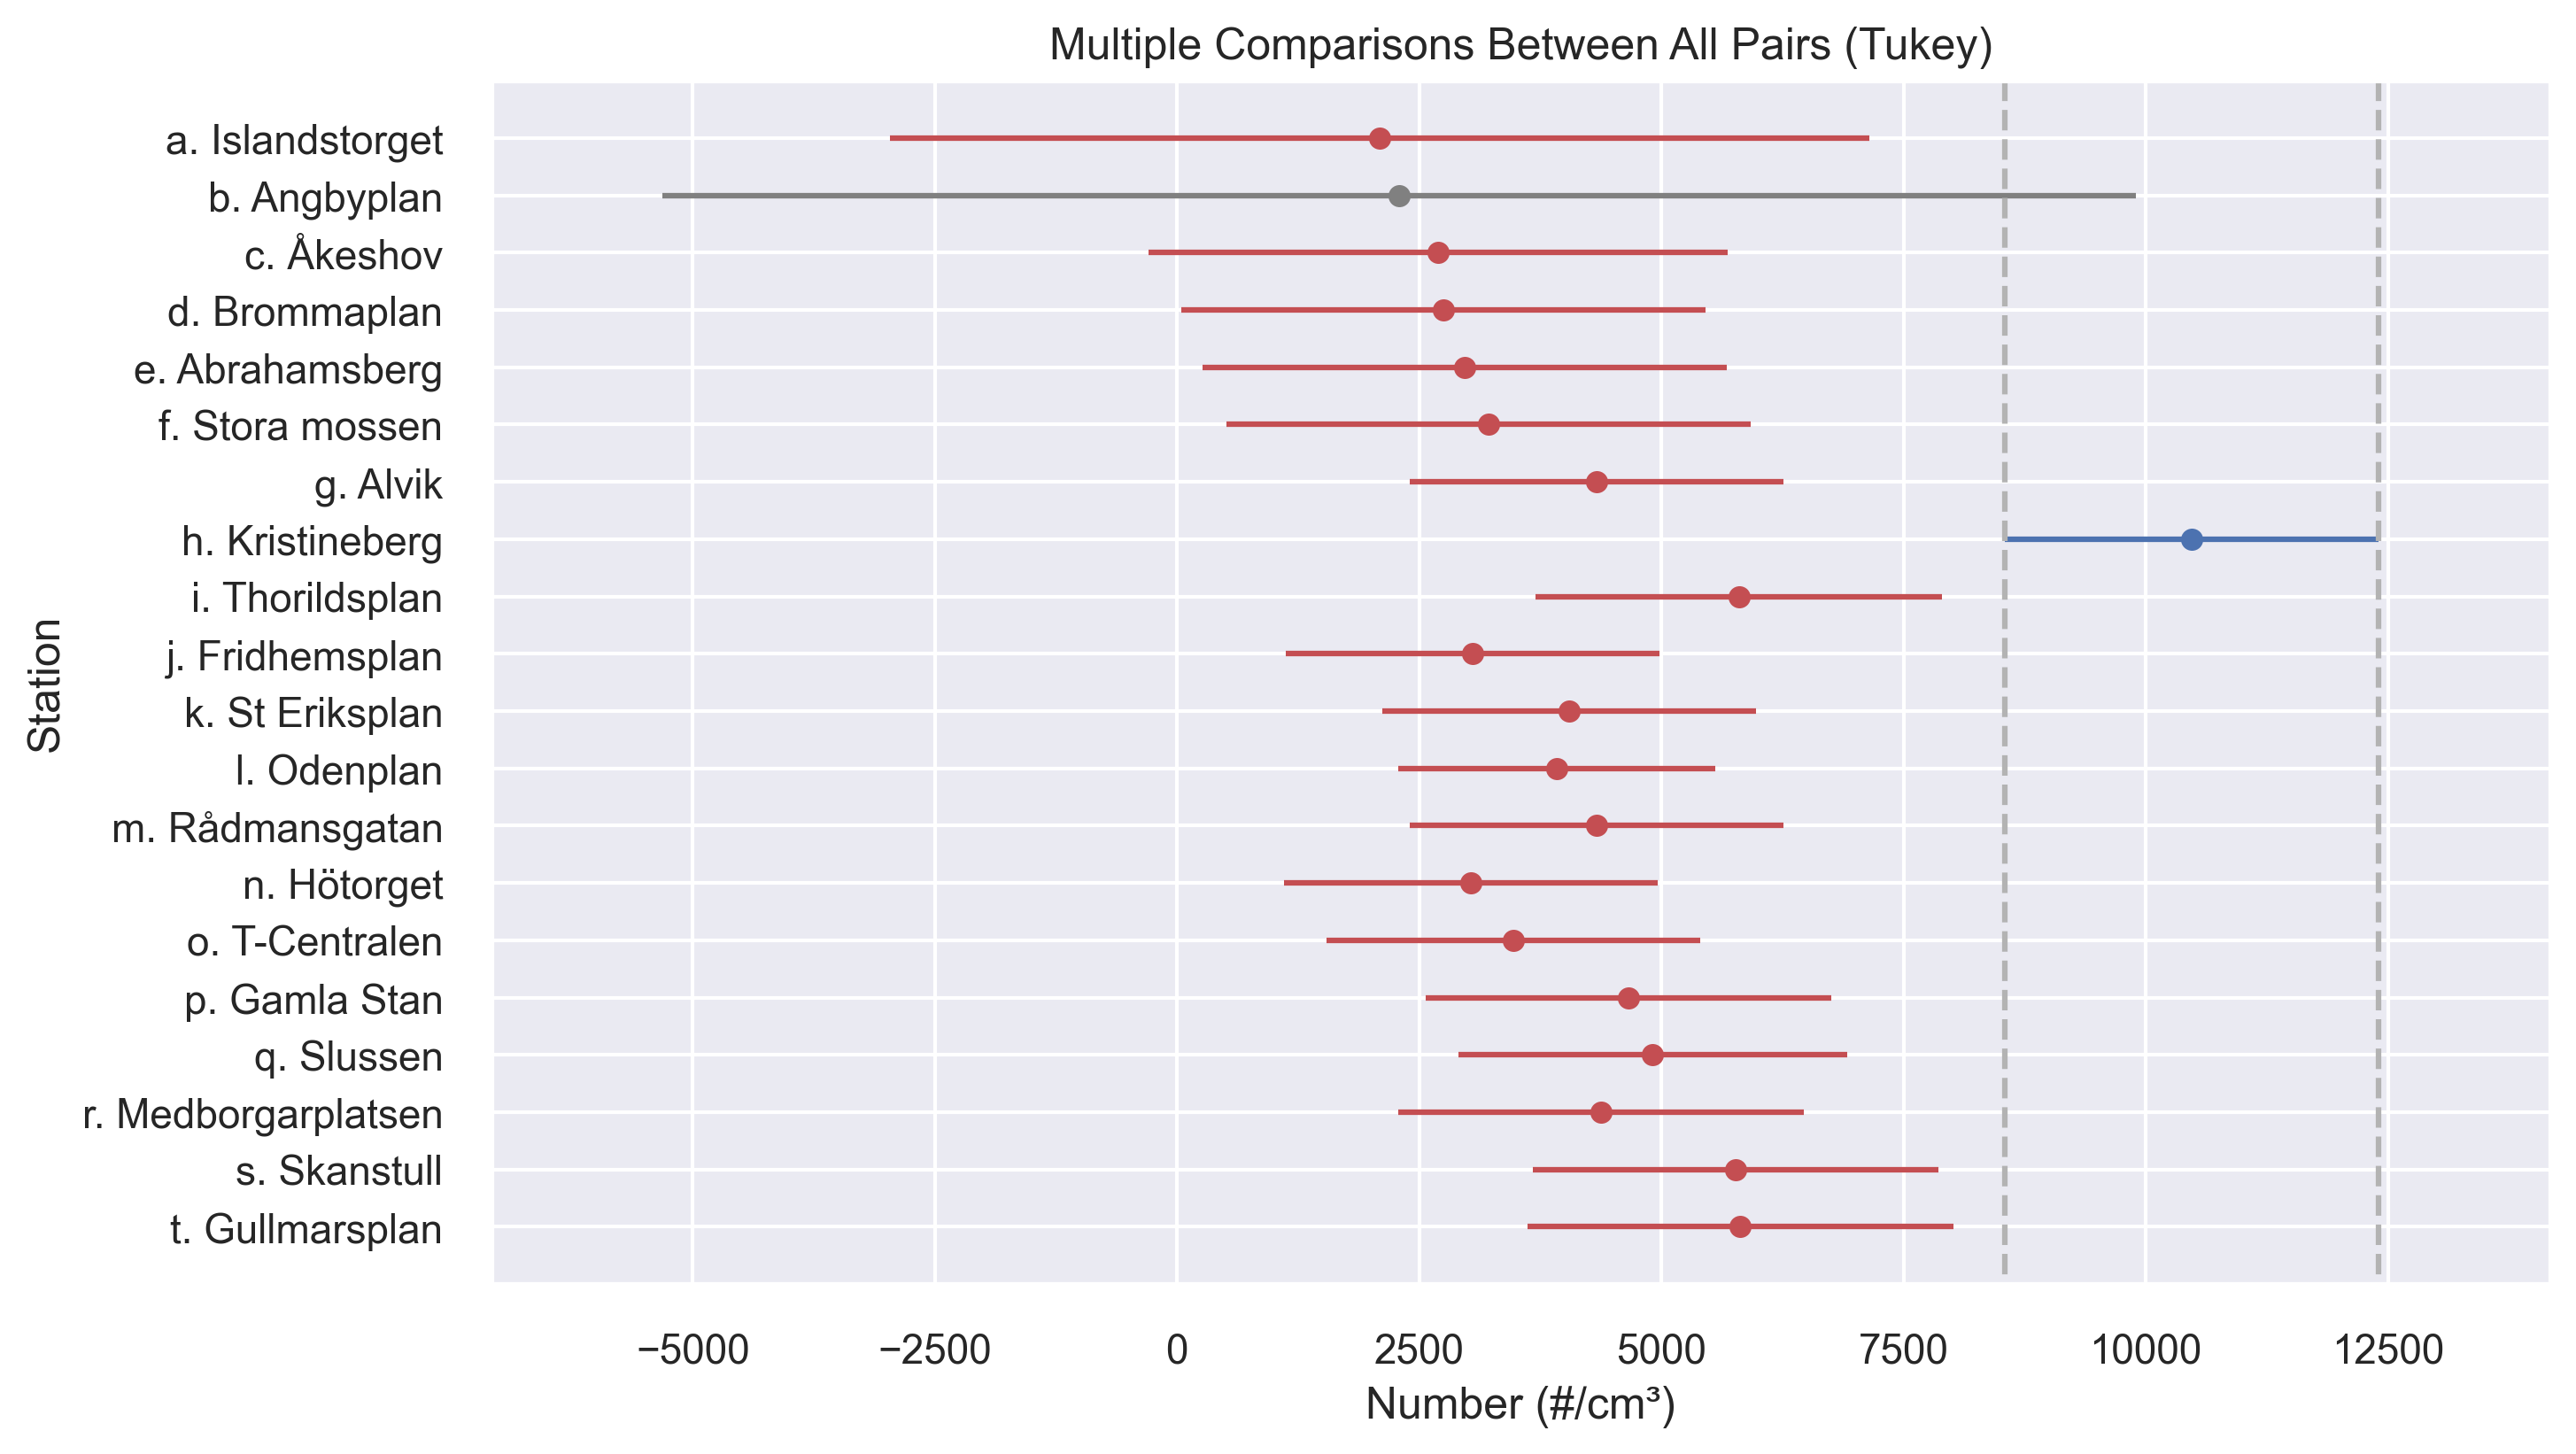

In [62]:
station_order = list(s_df['Station'].unique())
alphabet = list('abcdefghijklmnopqrstuvwxyz')

tukey_s_df = s_df.copy()

tukey_s_df['Station'] = s_df['Station'].apply(lambda x: f'{alphabet[station_order.index(x)]}. {x}')

tukey = pairwise_tukeyhsd(
    endog=tukey_s_df[param],
    groups=tukey_s_df['Station'],
    alpha=0.05
)

fig, ax = plt.subplots(dpi=300)

tukey.plot_simultaneous(
    comparison_name='h. Kristineberg', 
    ax=ax,
    xlabel=f'{param} ({unit})',
    ylabel='Station'
)


plt.gca().invert_yaxis()
#plt.ylim(['Odenplan', 'Islandstorget'])

plt.savefig(f'{fig_folder}/tukey_comparisons_all({param}).pdf', dpi=300, bbox_inches="tight")
plt.show()